In [15]:
import matplotlib.pyplot as plt
import numpy as np
import os
import sys
import pickle
import matplotlib
import ipyparams

path = os.getcwd().split(os.sep + 'GUI')[0]
if path not in sys.path:
    print("not here")
    sys.path.append(path)

from neurolib.models.aln import ALNModel
from neurolib.utils import plotFunctions as plotFunc
from neurolib.utils import func_optimize as fo
from neurolib.utils import costFunctions as cost
import neurolib.dashboard.functions as functions
import neurolib.dashboard.data as data
import neurolib.dashboard.layout as layout

    
# This will reload all imports as soon as the code changes
%load_ext autoreload
%autoreload 2 

#path = os.path.join(os.getcwd(), "plots")

cmap_ = layout.getcolormap()
darkgrey, midgrey, lightgrey, color_bi_updown, color_LC, color_bi_uposc = layout.getcolors()
exc_red = cmap_(3)
inh_blue=cmap_(0)
green = cmap_(2)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [16]:
aln = ALNModel()
N = aln.params.N

data.set_parameters(aln)

state_vars = aln.state_vars
init_vars = aln.init_vars

##############################################################
def setinit(init_vars_, model):
    state_vars = model.state_vars
    init_vars = model.init_vars
    for iv in range(len(init_vars)):
        for sv in range(len(state_vars)):
            if state_vars[sv] in init_vars[iv]:
                #print("set init vars ", )
                if model.params[init_vars[iv]].ndim == 2:
                    model.params[init_vars[iv]][0,:] = init_vars_[sv]
                else:
                    model.params[init_vars[iv]][0] = init_vars_[sv]
                    
##############################################################               
def setmaxmincontrol(max_c_c, min_c_c, max_c_r, min_c_r):
    import numpy as np
    
    max_cntrl = np.zeros(( 6 ))
    min_cntrl = np.zeros(( 6 ))
    
    max_cntrl[0] = max_c_c
    min_cntrl[0] = min_c_c
    max_cntrl[1] = max_c_c
    min_cntrl[1] = min_c_c
    max_cntrl[2] = max_c_r
    min_cntrl[2] = min_c_r
    max_cntrl[3] = max_c_r
    min_cntrl[3] = min_c_r
    max_cntrl[4] = max_c_r
    min_cntrl[4] = min_c_r
    max_cntrl[5] = max_c_r
    min_cntrl[5] = min_c_r
            
    return max_cntrl, min_cntrl

In [17]:
##### LOAD BOUNDARIES
data_file = '..' + os.sep + '..' + os.sep + 'bi.pickle'
with open(data_file,'rb') as f:
    load_array= pickle.load(f)
exc = load_array[0]
inh = load_array[1]

In [18]:
bestControl = [None] * len(exc)
bestState = [None] * len(exc)
cost_ = [None] * len(exc)
costnode = [None] * len(exc)
weights = [None] * len(exc)

In [19]:
initVars = [None] * len(exc)
target = [None] * len(exc)
cost_uncontrolled = [None] * len(exc)

In [20]:
dur_pre = 10
dur_post = 10
dur = 200.
dt = aln.params.dt
T = int(1 + dur / dt)

max_it = 10
init_it = 10
noise_realizations = 100
noise_realizations_final = 10000
prec_vars = [0,1]
trans_time = 0.9
repeat = 20

n_pre = int(np.around(dur_pre/aln.params.dt + 1.,1))
n_post = int(np.around(dur_post/aln.params.dt + 1.,1))

tol = 1e-32
start_step = 10.
c_scheme = np.zeros(( 1,1 ))
c_scheme[0,0] = 1.
u_mat = np.identity(1)
u_scheme = np.array([[1.]])

maxC = [5., -5., 0.18, 0.]
n_dur = int(np.around(dur/aln.params.dt + 1.,1))
max_cntrl, min_cntrl = setmaxmincontrol(maxC[0], maxC[1], maxC[2], maxC[3])

nb = ipyparams.notebook_name
print('nb = ', nb)

case = str(nb[4])

if case in ['1', '2']:
    max_I = [3., -3.]
elif case in ['3', '4']:
    max_I = [3., -3.]

read_file = '..' + os.sep + '..' + os.sep + 'data_final_2' + os.sep + 'control_' + case + '.pickle'
    
i_range = np.arange(0,83,1)
#i_range = [20,50]

stable_state = np.zeros(( len(exc), 2,2,2, 2))
final_folder = '.' + os.sep + nb[:5] + '_data' + os.sep
final_folder_plots = '.' + os.sep + nb[:5] + '_plots' + os.sep

file_nf_1 = os.path.join(final_folder, 'nf_1.pickle')
file_E = os.path.join(final_folder, 'E.pickle')
file_I = os.path.join(final_folder, 'I.pickle')

nb =  task1.ipynb


In [50]:
if os.path.isfile(read_file) :
    print("file found")
    
    with open(read_file,'rb') as f:
        load_array = pickle.load(f)

    bestControl = load_array[0]
    bestState = load_array[1]
    cost_ = load_array[2]
    costnode = load_array[3]
    weights = load_array[4]
    
init_control_noisefree = [None] * len(exc)
for i in i_range:
    init_control_noisefree[i] = bestControl[i].copy()

file found


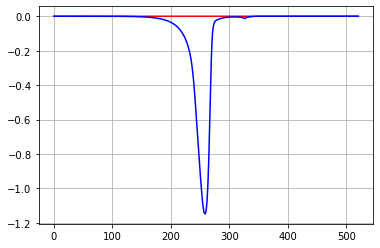

In [51]:
plt.plot(np.arange(0,520.1,0.1), init_control_noisefree[25][0,0,:], color='red')
plt.plot(np.arange(0,520.1,0.1), init_control_noisefree[25][0,1,:], color='blue')

In [23]:
# get init vars without noise
aln = ALNModel()
data.set_parameters(aln)
aln.params.duration = 3000.
aln.params.dt = 0.1

control0 = functions.step_control(aln, maxI_ = max_I[1])

# initial without noise
for i in i_range:
    print("------- ", i, exc[i], inh[i])
    aln.params.ext_exc_current = exc[i] * 5.
    aln.params.ext_inh_current = inh[i] * 5.

    aln.run(control=control0)

    init_state_vars = np.zeros(( len(state_vars) ))
    for j in range(len(state_vars)):
        if aln.state[state_vars[j]].size == 1:
            init_state_vars[j] = aln.state[state_vars[j]][0]
        else:
            init_state_vars[j] = aln.state[state_vars[j]][0,-1]

    initVars[i] = init_state_vars
    
    stable_state[i,0,0,0,0] = aln.rates_exc[0,-1]
    stable_state[i,0,0,1,0] = aln.rates_inh[0,-1]

# final state without noise
control0 = aln.getZeroControl()
control0[0,0,:500] = 5.
if case in ['3', '4']:
    control0[0,0,:500] = - 5.

for i in i_range:
    print("------- ", i, exc[i], inh[i])
    aln.params.ext_exc_current = exc[i] * 5.
    aln.params.ext_inh_current = inh[i] * 5.

    aln.params.duration = 3000.
    aln.run(control=control0)
    stable_state[i,0,1,0,0] = aln.rates_exc[0,-1]
    stable_state[i,0,1,1,0] = aln.rates_inh[0,-1]
    
    aln.params.duration = dur
    target_det = aln.getZeroTarget()
    target_det[:,0,:] = aln.rates_exc[0,-1]
    target_det[:,1,:] = aln.rates_inh[0,-1]
    
    print('exc low, high ', stable_state[i,0,0,0,0], stable_state[i,0,1,0,0])
    print('inh low, high ', stable_state[i,0,0,1,0], stable_state[i,0,1,1,0])

-------  0 0.4000000000000001 0.3500000000000001
-------  1 0.4250000000000001 0.3500000000000001
-------  2 0.4000000000000001 0.3750000000000001
-------  3 0.4250000000000001 0.3750000000000001
-------  4 0.4500000000000001 0.3750000000000001
-------  5 0.4000000000000001 0.40000000000000013
-------  6 0.4250000000000001 0.40000000000000013
-------  7 0.4500000000000001 0.40000000000000013
-------  8 0.47500000000000014 0.40000000000000013
-------  9 0.4000000000000001 0.42500000000000016
-------  10 0.4250000000000001 0.42500000000000016
-------  11 0.4500000000000001 0.42500000000000016
-------  12 0.47500000000000014 0.42500000000000016
-------  13 0.4000000000000001 0.4500000000000002
-------  14 0.4250000000000001 0.4500000000000002
-------  15 0.4500000000000001 0.4500000000000002
-------  16 0.47500000000000014 0.4500000000000002
-------  17 0.5000000000000002 0.4500000000000002
-------  18 0.4000000000000001 0.4750000000000002
-------  19 0.4250000000000001 0.4750000000000002

exc low, high  0.0003229813644409909 45.65211697202711
inh low, high  33.954740026080074 102.20031980246709
-------  40 0.5250000000000001 0.5500000000000003
exc low, high  0.0037309195899286286 50.532413571617454
inh low, high  34.006954861615405 102.82777603977352
-------  41 0.5500000000000003 0.5500000000000003
exc low, high  0.036596161175995116 55.16639955123652
inh low, high  34.50783187345211 103.32885318783167
-------  42 0.4250000000000001 0.5750000000000003
exc low, high  1.0198704804163782e-08 27.421129646010254
inh low, high  37.93423350773265 101.46473575049698
-------  43 0.4500000000000001 0.5750000000000003
exc low, high  2.943758083199642e-07 34.36666895729997
inh low, high  37.9342378681833 103.41851326508973
-------  44 0.47500000000000014 0.5750000000000003
exc low, high  6.651997717795215e-06 40.17091588973253
inh low, high  37.93433542026606 104.58741026573074
-------  45 0.5000000000000002 0.5750000000000003
exc low, high  0.0001106311855298747 45.41806731587161

In [24]:
# get target states with noise

sigma_ou = 0.1
aln.params.sigma_ou = sigma_ou


stateswitch_i = [0, 2, 5, 9, 13, 18, 24, 30, 36, 42, 48, 55, 62, 69, 76]

In [165]:
# set target with noise
aln.params.duration = 300.
control0 = aln.getZeroControl()
control0[0,0,:500] = 5.
if case in ['3', '4']:
    control0[0,0,:500] = - 5.

for i in i_range:
    
    if i in stateswitch_i:
        continue

    print("------- ", i, exc[i], inh[i])
    aln.params.ext_exc_current = exc[i] * 5.
    aln.params.ext_inh_current = inh[i] * 5.

    target_rates_e = []
    target_rates_i = []
    
    stateswitchcount = 0

    for j in range(noise_realizations_final):
        aln.params.duration = 300.
        aln.run(control=control0)
        if np.amin(aln.rates_exc[0,1000:]) < 1.:
            print("fell in down state, repeat")
            j -= 1
            stateswitchcount += 1
            if stateswitchcount > 0.1 * noise_realizations_final:
                stateswitch_i.append(i)
                break
            continue
        target_rates_e.append(aln.rates_exc[0,1000:])
        target_rates_i.append(aln.rates_inh[0,1000:])

    if case in ['1', '2']:
        aln.params.duration = dur
        target[i] = aln.getZeroTarget()
        target[i][:,0,:] = np.mean(target_rates_e)
        target[i][:,1,:] = np.mean(target_rates_i)
    
    stable_state[i,1,1,0,0] = target[i][0,0,-1]
    stable_state[i,1,1,1,0] = target[i][0,1,-1]
    stable_state[i,1,1,0,1] = np.std(target_rates_e)
    stable_state[i,1,1,1,1] = np.std(target_rates_i)    
    
aln.params.duration = 300.
control0 = aln.getZeroControl()
control0[0,0,:500] = -5.

for i in i_range:
    if i in stateswitch_i:
        continue
    print("------- ", i, exc[i], inh[i])
    aln.params.ext_exc_current = exc[i] * 5.
    aln.params.ext_inh_current = inh[i] * 5.

    target_rates_e = []
    target_rates_i = []
    
    stateswitchcount = 0

    for j in range(noise_realizations_final):
        aln.params.duration = 300.
        aln.run(control=control0)
        if np.amin(aln.rates_exc[0,1000:]) > 3.:
            print("fell in up state, repeat")
            j -= 1
            stateswitchcount += 1
            if stateswitchcount > 0.1 * noise_realizations_final:
                stateswitch_i.append(i)
                break
            continue
        target_rates_e.append(aln.rates_exc[0,1000:])
        target_rates_i.append(aln.rates_inh[0,1000:])
        
    if case in ['3', '4']:
        aln.params.duration = dur
        target[i] = aln.getZeroTarget()
        target[i][:,0,:] = np.mean(target_rates_e)
        target[i][:,1,:] = np.mean(target_rates_i)

    stable_state[i,1,0,0,0] = np.mean(target_rates_e)
    stable_state[i,1,0,1,0] = np.mean(target_rates_i)
    stable_state[i,1,0,0,1] = np.std(target_rates_e)
    stable_state[i,1,0,1,1] = np.std(target_rates_i)
    
print(stateswitch_i)

-------  1 0.4250000000000001 0.3500000000000001
fell in down state, repeat
fell in down state, repeat
fell in down state, repeat
fell in down state, repeat
fell in down state, repeat
fell in down state, repeat
fell in down state, repeat
fell in down state, repeat
fell in down state, repeat
fell in down state, repeat
fell in down state, repeat
fell in down state, repeat
fell in down state, repeat
fell in down state, repeat
fell in down state, repeat
fell in down state, repeat
fell in down state, repeat
fell in down state, repeat
fell in down state, repeat
fell in down state, repeat
fell in down state, repeat
fell in down state, repeat
fell in down state, repeat
fell in down state, repeat
fell in down state, repeat
-------  3 0.4250000000000001 0.3750000000000001
fell in down state, repeat
fell in down state, repeat
fell in down state, repeat
fell in down state, repeat
fell in down state, repeat
fell in down state, repeat
fell in down state, repeat
fell in down state, repeat
fell in dow

fell in down state, repeat
fell in down state, repeat
fell in down state, repeat
fell in down state, repeat
fell in down state, repeat
fell in down state, repeat
fell in down state, repeat
fell in down state, repeat
fell in down state, repeat
fell in down state, repeat
fell in down state, repeat
fell in down state, repeat
fell in down state, repeat
fell in down state, repeat
fell in down state, repeat
fell in down state, repeat
fell in down state, repeat
fell in down state, repeat
fell in down state, repeat
fell in down state, repeat
fell in down state, repeat
fell in down state, repeat
fell in down state, repeat
fell in down state, repeat
fell in down state, repeat
fell in down state, repeat
fell in down state, repeat
fell in down state, repeat
fell in down state, repeat
fell in down state, repeat
fell in down state, repeat
fell in down state, repeat
fell in down state, repeat
fell in down state, repeat
fell in down state, repeat
fell in down state, repeat
fell in down state, repeat
f

fell in down state, repeat
fell in down state, repeat
fell in down state, repeat
fell in down state, repeat
fell in down state, repeat
fell in down state, repeat
fell in down state, repeat
fell in down state, repeat
fell in down state, repeat
fell in down state, repeat
fell in down state, repeat
fell in down state, repeat
fell in down state, repeat
fell in down state, repeat
fell in down state, repeat
fell in down state, repeat
fell in down state, repeat
fell in down state, repeat
fell in down state, repeat
fell in down state, repeat
fell in down state, repeat
fell in down state, repeat
fell in down state, repeat
fell in down state, repeat
fell in down state, repeat
fell in down state, repeat
fell in down state, repeat
fell in down state, repeat
fell in down state, repeat
fell in down state, repeat
fell in down state, repeat
fell in down state, repeat
fell in down state, repeat
fell in down state, repeat
fell in down state, repeat
fell in down state, repeat
fell in down state, repeat
f

fell in down state, repeat
fell in down state, repeat
fell in down state, repeat
fell in down state, repeat
fell in down state, repeat
fell in down state, repeat
fell in down state, repeat
fell in down state, repeat
fell in down state, repeat
fell in down state, repeat
fell in down state, repeat
fell in down state, repeat
fell in down state, repeat
fell in down state, repeat
fell in down state, repeat
fell in down state, repeat
fell in down state, repeat
fell in down state, repeat
fell in down state, repeat
fell in down state, repeat
fell in down state, repeat
fell in down state, repeat
fell in down state, repeat
fell in down state, repeat
fell in down state, repeat
fell in down state, repeat
fell in down state, repeat
fell in down state, repeat
fell in down state, repeat
fell in down state, repeat
fell in down state, repeat
fell in down state, repeat
fell in down state, repeat
fell in down state, repeat
fell in down state, repeat
fell in down state, repeat
fell in down state, repeat
f

fell in down state, repeat
fell in down state, repeat
fell in down state, repeat
fell in down state, repeat
fell in down state, repeat
fell in down state, repeat
fell in down state, repeat
fell in down state, repeat
fell in down state, repeat
fell in down state, repeat
fell in down state, repeat
fell in down state, repeat
fell in down state, repeat
fell in down state, repeat
fell in down state, repeat
fell in down state, repeat
fell in down state, repeat
fell in down state, repeat
fell in down state, repeat
fell in down state, repeat
fell in down state, repeat
fell in down state, repeat
fell in down state, repeat
fell in down state, repeat
fell in down state, repeat
fell in down state, repeat
fell in down state, repeat
fell in down state, repeat
fell in down state, repeat
fell in down state, repeat
fell in down state, repeat
fell in down state, repeat
fell in down state, repeat
fell in down state, repeat
fell in down state, repeat
fell in down state, repeat
fell in down state, repeat
f

fell in down state, repeat
fell in down state, repeat
fell in down state, repeat
fell in down state, repeat
fell in down state, repeat
fell in down state, repeat
fell in down state, repeat
fell in down state, repeat
fell in down state, repeat
fell in down state, repeat
fell in down state, repeat
fell in down state, repeat
fell in down state, repeat
fell in down state, repeat
fell in down state, repeat
fell in down state, repeat
fell in down state, repeat
fell in down state, repeat
fell in down state, repeat
fell in down state, repeat
fell in down state, repeat
fell in down state, repeat
fell in down state, repeat
fell in down state, repeat
fell in down state, repeat
fell in down state, repeat
fell in down state, repeat
fell in down state, repeat
fell in down state, repeat
fell in down state, repeat
fell in down state, repeat
fell in down state, repeat
fell in down state, repeat
fell in down state, repeat
fell in down state, repeat
fell in down state, repeat
fell in down state, repeat
f

fell in down state, repeat
fell in down state, repeat
fell in down state, repeat
fell in down state, repeat
fell in down state, repeat
fell in down state, repeat
fell in down state, repeat
fell in down state, repeat
fell in down state, repeat
fell in down state, repeat
fell in down state, repeat
fell in down state, repeat
fell in down state, repeat
fell in down state, repeat
fell in down state, repeat
fell in down state, repeat
fell in down state, repeat
fell in down state, repeat
fell in down state, repeat
fell in down state, repeat
fell in down state, repeat
fell in down state, repeat
fell in down state, repeat
fell in down state, repeat
fell in down state, repeat
fell in down state, repeat
fell in down state, repeat
fell in down state, repeat
fell in down state, repeat
fell in down state, repeat
fell in down state, repeat
fell in down state, repeat
fell in down state, repeat
fell in down state, repeat
fell in down state, repeat
fell in down state, repeat
fell in down state, repeat
f

fell in down state, repeat
fell in down state, repeat
fell in down state, repeat
fell in down state, repeat
fell in down state, repeat
fell in down state, repeat
fell in down state, repeat
fell in down state, repeat
-------  32 0.47500000000000014 0.5250000000000002
-------  33 0.5000000000000002 0.5250000000000002
-------  34 0.5250000000000001 0.5250000000000002
-------  35 0.5500000000000003 0.5250000000000002
-------  37 0.4500000000000001 0.5500000000000003
fell in down state, repeat
fell in down state, repeat
fell in down state, repeat
fell in down state, repeat
fell in down state, repeat
fell in down state, repeat
-------  38 0.47500000000000014 0.5500000000000003
-------  39 0.5000000000000002 0.5500000000000003
-------  40 0.5250000000000001 0.5500000000000003
-------  41 0.5500000000000003 0.5500000000000003
-------  43 0.4500000000000001 0.5750000000000003
fell in down state, repeat
fell in down state, repeat
fell in down state, repeat
fell in down state, repeat
fell in down

-------  49 0.4500000000000001 0.6000000000000003
-------  50 0.47500000000000014 0.6000000000000003
-------  51 0.5000000000000002 0.6000000000000003
-------  52 0.5250000000000001 0.6000000000000003
-------  53 0.5500000000000003 0.6000000000000003
-------  54 0.5750000000000002 0.6000000000000003
-------  56 0.4500000000000001 0.6250000000000003
-------  57 0.47500000000000014 0.6250000000000003
-------  58 0.5000000000000002 0.6250000000000003
-------  59 0.5250000000000001 0.6250000000000003
-------  60 0.5500000000000003 0.6250000000000003
-------  61 0.5750000000000002 0.6250000000000003
-------  63 0.4500000000000001 0.6500000000000004
-------  64 0.47500000000000014 0.6500000000000004
-------  65 0.5000000000000002 0.6500000000000004
-------  66 0.5250000000000001 0.6500000000000004
-------  67 0.5500000000000003 0.6500000000000004
-------  68 0.5750000000000002 0.6500000000000004
-------  70 0.4500000000000001 0.6750000000000004
-------  71 0.47500000000000014 0.6750000000000

In [25]:
if os.path.isfile('target_taks1.pickle') :
    print("file found")
    
    with open('target_taks1.pickle','rb') as f:
        load_array = pickle.load(f)

    tar_ = load_array[0]
    stab_st = load_array[1]
    
for i in i_range:
    if i in stateswitch_i:
        continue
    target[i] = tar_[i].copy()
    stable_state[i] = stab_st[i]

file found


In [ ]:
with open('target_taks1.pickle','wb') as f:
    pickle.dump([target, stable_state], f)

In [26]:
for i in i_range:
    if i in stateswitch_i:
        continue
        
    print(i)
    print('exc low with noise ', stable_state[i,1,0,0,0], ' +- ', stable_state[i,1,0,0,1])
    print('exc high with noise ', stable_state[i,1,1,0,0], ' +- ', stable_state[i,1,1,0,1])
    print('inh low with noise ', stable_state[i,1,0,1,0], ' +- ', stable_state[i,1,0,1,1])
    print('inh high with noise ', stable_state[i,1,1,1,0], ' +- ', stable_state[i,1,1,1,1])

1
exc low with noise  17.977462863023042  +-  15.279595469229706
exc high with noise  31.41581374174236  +-  6.17832161264087
inh low with noise  46.68356075724349  +-  27.937487593461984
inh high with noise  71.18921068149002  +-  4.960002544866639
3
exc low with noise  5.290677065659226  +-  11.013427860694241
exc high with noise  30.681330905862502  +-  6.314180501757982
inh low with noise  24.139412113652092  +-  22.914370406698048
inh high with noise  74.56828604594403  +-  4.999249313130352
4
exc low with noise  20.113471353680662  +-  17.986650847770388
exc high with noise  37.14001030388652  +-  5.7141456380852516
inh low with noise  48.89596539114521  +-  29.7995520769901
inh high with noise  76.49384007639732  +-  4.570647539277276
6
exc low with noise  0.40809664299993015  +-  2.9760749165101594
exc high with noise  30.002060345523503  +-  6.371044560509344
inh low with noise  14.61396014158634  +-  7.734154861537282
inh high with noise  77.88844843878547  +-  5.049908503597

In [27]:
diff_low = np.zeros(( 83,2 ))
diff_high = np.zeros(( 83,2 ))

for i in i_range:
    if i in stateswitch_i:
        continue
        
    print('------  ', i)
    diff_low[i,:] = [stable_state[i,0,0,0,0] - stable_state[i,1,0,0,0],
                stable_state[i,0,0,1,0] - stable_state[i,1,0,1,0]]
    print("difference in low rate exc/ inh: ", diff_low[i,:])
    print("std dev low rate exc/ inh: ", stable_state[i,1,0,0,1], stable_state[i,1,0,1,1])
    diff_high[i,:] =  [stable_state[i,0,1,0,0] - stable_state[i,1,1,0,0],
                 stable_state[i,0,1,1,0] - stable_state[i,1,1,1,0]]
    print("difference in high rate exc/ inh: ", diff_high[i,:])
    print("std dev high rate exc/ inh: ", stable_state[i,1,1,0,1], stable_state[i,1,1,1,1])

------   1
difference in low rate exc/ inh:  [-17.3082138  -33.08512946]
std dev low rate exc/ inh:  15.279595469229706 27.937487593461984
difference in high rate exc/ inh:  [0.58436555 0.57804122]
std dev high rate exc/ inh:  6.17832161264087 4.960002544866639
------   3
difference in low rate exc/ inh:  [ -5.09150989 -12.04864041]
std dev low rate exc/ inh:  11.013427860694241 22.914370406698048
difference in high rate exc/ inh:  [0.67159831 0.64138579]
std dev high rate exc/ inh:  6.314180501757982 4.999249313130352
------   4
difference in low rate exc/ inh:  [-19.5459886 -33.3219105]
std dev low rate exc/ inh:  17.986650847770388 29.7995520769901
difference in high rate exc/ inh:  [0.30872328 0.28597165]
std dev high rate exc/ inh:  5.7141456380852516 4.570647539277276
------   6
difference in low rate exc/ inh:  [-0.38091688 -1.6046608 ]
std dev low rate exc/ inh:  2.9760749165101594 7.734154861537282
difference in high rate exc/ inh:  [0.74819989 0.72852729]
std dev high rate ex

In [28]:
aln.params.sigma_ou = sigma_ou


w_p_0 = np.zeros(( len(exc) ))
w_p_1 = np.zeros(( len(exc) ))
w_p = np.zeros(( len(exc) ))

for i in i_range:
    if i in stateswitch_i:
        continue
        
    w_p_0[i] = 1. / ( (stable_state[i,1,1,0,1]) * (1. - trans_time) * dur / aln.params.dt )
    w_p_1[i] = 1. / ( (stable_state[i,1,1,1,1]) * (1. - trans_time) * dur / aln.params.dt )
    w_p[i] = 1. / ( ( stable_state[i,1,1,0,1] + stable_state[i,1,1,1,1] ) * (1. - trans_time) * dur / aln.params.dt )

if case in ['1', '3']:
    w_e = 0.
    w_s = 1.
elif case in ['2', '4']:
    w_e = 1.
    w_s = 0.

aln.params.duration = dur
zero_init = aln.getZeroControl()

In [29]:
cost_E_final = [None] * len(exc)
cost_I_final = [None] * len(exc)
cost_nf_final = [None] * len(exc)
cost_nf_1_final = [None] * len(exc)
cost_rect_E_final = [None] * len(exc)
cost_rect_I_final = [None] * len(exc)

In [30]:
control_E = [None] * len(exc)
cost_E = [None] * len(exc)
cost_E_final = [None] * len(exc)
file_E = os.path.join(final_folder, 'E.pickle')

In [31]:
control_I = [None] * len(exc)
cost_I = [None] * len(exc)
cost_I_final = [None] * len(exc)
file_I = os.path.join(final_folder, 'I.pickle')

In [40]:
control_nf = [None] * len(exc)
cost_nf = [None] * len(exc)
cost_nf_final = [None] * len(exc)
cost_nf_final_mean = np.zeros(( len(exc) ))

In [33]:
control_nf_1 = [None] * len(exc)
cost_nf_1 = [None] * len(exc)
cost_nf_1_final = [None] * len(exc)
file_nf_1 = os.path.join(final_folder, 'nf_1.pickle')

In [34]:
rect_E = [None] * len(exc)
cost_rect_E = [None] * len(exc)
cost_rect_E_final = [None] * len(exc)

In [35]:
rect_I = [None] * len(exc)
cost_rect_I = [None] * len(exc)
cost_rect_I_final = [None] * len(exc)

In [161]:
# E init

max_it = 25

for i in i_range:
    
    cost.setParams(w_p[i], w_e, w_s)
    
    aln.params.ext_exc_current = exc[i] * 5.
    aln.params.ext_inh_current = inh[i] * 5.
    
    if i >= 10:
        break

    print("------- ", i, exc[i], inh[i], noise_realizations)
    if i in stateswitch_i:
        continue
    
    control_list = []
    cost_list = []
    
    setinit(initVars[i], aln)
    aln.params.duration = dur
    
    zero_init = aln.getZeroControl()

    bestControl[i], bestState[i], cost_[i], runtime, grad, phi, costnode[i], total_cost_mean_std = aln.A1(
        zero_init, target[i], c_scheme, u_mat, u_scheme, max_iteration_ = init_it,
        tolerance_ = tol, startStep_ = start_step, max_control_ = max_cntrl, min_control_ = min_cntrl,
        t_sim_ = dur, t_sim_pre_ = dur_pre, t_sim_post_ = dur_post, CGVar = None,
        control_variables_ = [0], prec_variables_ = prec_vars, transition_time_ = trans_time,
        noise_real=noise_realizations, init_params = initVars[i], method='M3')

    control_init = bestControl[i][:,:,100:-100]
    setinit(initVars[i], aln)
    
    plt.plot(np.arange(0,dur+aln.params.dt,aln.params.dt), control_init[0,0,:]/5., color=exc_red)
    plt.plot(np.arange(0,dur+aln.params.dt,aln.params.dt), control_init[0,1,:]/5., color=inh_blue)
    plt.show()
    
    bestControl[i], bestState[i], cost_[i], runtime, grad, phi, costnode[i], total_cost_mean_std = aln.A1(
        control_init, target[i], c_scheme, u_mat, u_scheme, max_iteration_ = max_it,
        tolerance_ = tol, startStep_ = start_step, max_control_ = max_cntrl, min_control_ = min_cntrl,
        t_sim_ = dur, t_sim_pre_ = dur_pre, t_sim_post_ = dur_post, CGVar = None,
        control_variables_ = [0,1], prec_variables_ = prec_vars, transition_time_ = trans_time,
        noise_real=noise_realizations, init_params = initVars[i], method='M3')

    control_E[i] = bestControl[i]
    cost_minind = 0
    cost_E[i] = np.zeros(( max_it ))
    for k in range(len(cost_E[i])):
        cost_E[i][k] = np.mean(cost_[i][:,k])
        if cost_E[i][k] > 0.:
            cost_minind = k

    print(cost_E[i])
    
    with open(file_E,'wb') as f:
        pickle.dump([control_E, cost_E], f)

set cost params:  0.0 0.0 1.0
-------  0 0.4000000000000001 0.3500000000000001 100
set cost params:  inf 0.0 1.0
set cost params:  0.0 0.0 1.0
-------  2 0.4000000000000001 0.3750000000000001 100
set cost params:  inf 0.0 1.0
set cost params:  inf 0.0 1.0
set cost params:  0.0 0.0 1.0
-------  5 0.4000000000000001 0.40000000000000013 100
set cost params:  inf 0.0 1.0
-------  6 0.4250000000000001 0.40000000000000013 100
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  inf
Gradient descend method:  None


KeyboardInterrupt: 

In [36]:
if os.path.isfile(file_E) :
    print("file found")
    
    with open(file_E,'rb') as f:
        load_array = pickle.load(f)

    control_ = load_array[0]
    cost_ = load_array[1]
    
for i in i_range:
    if i in stateswitch_i:
        continue
    if type(control_[i]) == type(None):
        continue
    control_E[i] = control_[i].copy()

file found


-------  20 0.4500000000000001 0.4750000000000002
repeat  0
set cost params:  0.0004852946241771807 0.0 1.0
interpolate adjoint :  True True True


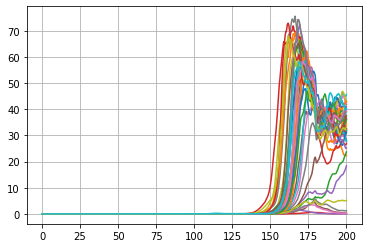

RUN  0 , total integrated cost =  36.072873439166244
Gradient descend method:  None
RUN  1 , total integrated cost =  6.670066965262535
RUN  2 , total integrated cost =  6.591981848749585
RUN  3 , total integrated cost =  6.3522938127580835
RUN  4 , total integrated cost =  6.407831137222582
RUN  5 , total integrated cost =  6.466452739478143
RUN  6 , total integrated cost =  6.322016403091948
RUN  7 , total integrated cost =  6.623082051928736
RUN  8 , total integrated cost =  6.737293633281186
no cost improvement
RUN  9 , total integrated cost =  6.749055736056837
RUN  10 , total integrated cost =  6.35127668068524
RUN  10 , total integrated cost mean =  6.35127668068524
Improved over  10  iterations in  18.88799490602105  seconds by  82.39320554433759  percent.


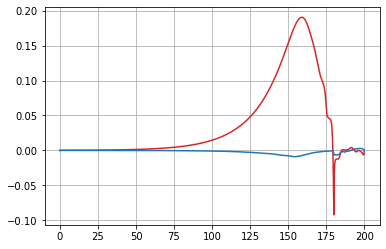

-------  50 0.47500000000000014 0.6000000000000003
repeat  0
set cost params:  0.000516623046832989 0.0 1.0
interpolate adjoint :  True True True


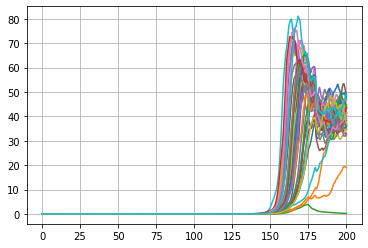

RUN  0 , total integrated cost =  16.133941056159294
Gradient descend method:  None
RUN  1 , total integrated cost =  7.751620010712839
RUN  2 , total integrated cost =  7.480142557791636
RUN  3 , total integrated cost =  7.569145230024796
RUN  4 , total integrated cost =  7.684906773067917
RUN  5 , total integrated cost =  7.58774965244682
RUN  6 , total integrated cost =  7.665940702768276
no cost improvement
RUN  7 , total integrated cost =  7.694423812028188
RUN  8 , total integrated cost =  7.704104365517713
RUN  9 , total integrated cost =  7.756146332080691
RUN  10 , total integrated cost =  7.498819011023085
RUN  10 , total integrated cost mean =  7.498819011023085
Improved over  10  iterations in  24.448836447991198  seconds by  53.521467662977884  percent.


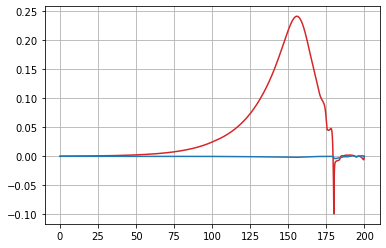

In [176]:
for i in i_range:
    
    aln.params.ext_exc_current = exc[i] * 5.
    aln.params.ext_inh_current = inh[i] * 5.

    print("------- ", i, exc[i], inh[i])
    if i in stateswitch_i:
        continue
    
    for k in range(1):
        print("repeat ", k)
    
        control_list = []
        cost_list = []
        aln.params.duration = dur

        cost.setParams(w_p[i], w_e, w_s)
        control_init = control_E[i][:,:,100:-100]
        setinit(initVars[i], aln)

        bestControl[i], bestState[i], cost_[i], runtime, grad, phi, costnode[i], total_cost_mean_std = aln.A1(
            control_init, target[i], c_scheme, u_mat, u_scheme, max_iteration_ = 10,
            tolerance_ = tol, startStep_ = start_step, max_control_ = max_cntrl, min_control_ = min_cntrl,
            t_sim_ = dur, t_sim_pre_ = dur_pre, t_sim_post_ = dur_post, CGVar = None,
            control_variables_ = [0,1], prec_variables_ = prec_vars, transition_time_ = trans_time,
            noise_real= noise_realizations, init_params = initVars[i], method='M3')

        control_init = bestControl[i][:,:,100:-100]
        setinit(initVars[i], aln)

        plt.plot(np.arange(0,dur+aln.params.dt,aln.params.dt), control_init[0,0,:]/5., color=exc_red)
        plt.plot(np.arange(0,dur+aln.params.dt,aln.params.dt), control_init[0,1,:]/5., color=inh_blue)
        plt.show()

        control_E[i] = bestControl[i].copy()
        
        #cost_minind = 0
        #cost_E[i] = np.zeros(( max_it ))
        #for k in range(len(cost_E[i])):
        #    cost_E[i][k] = np.mean(cost_[i][:,k])
        #    if cost_E[i][k] > 0.:
        #        cost_minind = k

        #with open(file_E,'wb') as f:
        #    pickle.dump([control_E, cost_E], f)

In [28]:
for i in i_range:
    
    aln.params.ext_exc_current = exc[i] * 5.
    aln.params.ext_inh_current = inh[i] * 5.

    print("------- ", i, exc[i], inh[i])
    if i in stateswitch_i:
        continue
    
    aln.params.duration = dur
    init_control = aln.getZeroControl()           
    init_control[:,:,:] = control_E[i][:,:,100:-100]
        
    target_ = target[i].copy()
    target_[0,0,:int(trans_time * dur / aln.params.dt)] = -1000
    target_[0,1,:int(trans_time * dur / aln.params.dt)] = -1000
    
    cost_E_final[i] = np.zeros(( noise_realizations_final ))
    
    for n_ in range(noise_realizations_final):
    
        setinit(initVars[i], aln)
        state_ = fo.updateState(aln, init_control)
        cost_E_final[i][n_] += cost.numba_cost_precision_int(1,T,dt,w_p[i],state_, target_, list(prec_vars) )
        cost_E_final[i][n_] += cost.numba_cost_sparsity_int(1, 6, T, w_s, dt, init_control)
        
    print(np.mean(cost_E_final[i]))

-------  10 0.4250000000000001 0.42500000000000016
8.383667599300782
-------  20 0.4500000000000001 0.4750000000000002
8.81865410078766
-------  30 0.4250000000000001 0.5250000000000002
-------  40 0.5250000000000001 0.5500000000000003
6.769924698204399
-------  50 0.47500000000000014 0.6000000000000003
9.744221429915177
-------  60 0.5500000000000003 0.6250000000000003
6.611050441706926


-------  30 0.4250000000000001 0.5250000000000002 100
-------  50 0.47500000000000014 0.6000000000000003 100
set cost params:  0.0005164616969688605 0.0 1.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  26.496183799443415
Gradient descend method:  None
RUN  1 , total integrated cost =  25.3822309569425
RUN  2 , total integrated cost =  25.80375636080631
RUN  3 , total integrated cost =  25.037559768529512
RUN  4 , total integrated cost =  26.975422399424875
RUN  5 , total integrated cost =  26.021199646059355
no cost improvement
RUN  6 , total integrated cost =  26.42651813863415
RUN  7 , total integrated cost =  26.85439786247585
RUN  8 , total integrated cost =  27.04159658065417
RUN  9 , total integrated cost =  27.762979129638946
RUN  10 , total integrated cost =  26.751244134463853
RUN  10 , total integrated cost mean =  26.751244134463853
Improved over  10  iterations in  78.48507191300087  seconds by  -0.9626304563368677  percent.


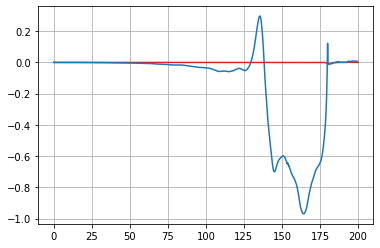

interpolate adjoint :  True True True
RUN  0 , total integrated cost =  26.727681627119146
Gradient descend method:  None
RUN  1 , total integrated cost =  25.60087611119923
RUN  2 , total integrated cost =  25.722611313545755
RUN  3 , total integrated cost =  25.643741795315126
RUN  4 , total integrated cost =  25.758271241337084
RUN  5 , total integrated cost =  25.723653935961664
no cost improvement
RUN  6 , total integrated cost =  25.946538172922384
RUN  7 , total integrated cost =  25.620979160943318
RUN  8 , total integrated cost =  25.711762460747693
RUN  8 , total integrated cost mean =  25.711762460747693
Improved over  8  iterations in  167.22505039000316  seconds by  3.8009999540725374  percent.


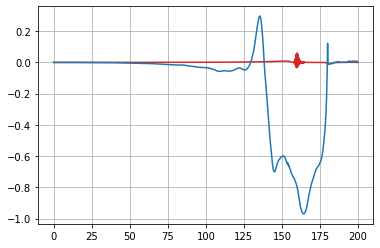

In [54]:
# I init

for i in i_range:
    
    if i in [10,20,40,60]:
        continue
    
    aln.params.ext_exc_current = exc[i] * 5.
    aln.params.ext_inh_current = inh[i] * 5.

    print("------- ", i, exc[i], inh[i], noise_realizations)
    if i in stateswitch_i:
        continue
    
    control_list = []
    cost_list = []
    
    setinit(initVars[i], aln)
    aln.params.duration = dur
    
    pulse_init = zero_init.copy()
    pulse_init = 2. * bestControl[60][:,:,100:-100].copy()
        
    cost.setParams(w_p[i], w_e, w_s)

    bestControl[i], bestState[i], cost_[i], runtime, grad, phi, costnode[i], total_cost_mean_std = aln.A1(
        pulse_init, target[i], c_scheme, u_mat, u_scheme, max_iteration_ = init_it,
        tolerance_ = tol, startStep_ = start_step, max_control_ = max_cntrl, min_control_ = min_cntrl,
        t_sim_ = dur, t_sim_pre_ = dur_pre, t_sim_post_ = dur_post, CGVar = None,
        control_variables_ = [1], prec_variables_ = prec_vars, transition_time_ = trans_time,
        noise_real=noise_realizations, init_params = initVars[i], method='M3')

    control_init = bestControl[i][:,:,100:-100]
    setinit(initVars[i], aln)
    
    plt.plot(np.arange(0,dur+aln.params.dt,aln.params.dt), control_init[0,0,:]/5., color=exc_red)
    plt.plot(np.arange(0,dur+aln.params.dt,aln.params.dt), control_init[0,1,:]/5., color=inh_blue)
    plt.show()
                    
    bestControl[i], bestState[i], cost_[i], runtime, grad, phi, costnode[i], total_cost_mean_std = aln.A1(
        control_init, target[i], c_scheme, u_mat, u_scheme, max_iteration_ = max_it,
        tolerance_ = tol, startStep_ = start_step, max_control_ = max_cntrl, min_control_ = min_cntrl,
        t_sim_ = dur, t_sim_pre_ = dur_pre, t_sim_post_ = dur_post, CGVar = None,
        control_variables_ = [0,1], prec_variables_ = prec_vars, transition_time_ = trans_time,
        noise_real=noise_realizations, init_params = initVars[i], method='M2')
    
    control_init = bestControl[i][:,:,100:-100]
    setinit(initVars[i], aln)
    
    plt.plot(np.arange(0,dur+aln.params.dt,aln.params.dt), control_init[0,0,:]/5., color=exc_red)
    plt.plot(np.arange(0,dur+aln.params.dt,aln.params.dt), control_init[0,1,:]/5., color=inh_blue)
    plt.show()

    control_I[i] = bestControl[i]
    cost_minind = 0
    cost_I[i] = np.zeros(( max_it ))
    for k in range(len(cost_I[i])):
        cost_I[i][k] = np.mean(cost_[i][:,k])
        if cost_I[i][k] > 0.:
            cost_minind = k

    #print(cost_I[i])
    
    with open(file_I,'wb') as f:
        pickle.dump([control_I, cost_I], f)

In [37]:
if os.path.isfile(file_I) :
    print("file found")
    
    with open(file_I,'rb') as f:
        load_array = pickle.load(f)

    control_ = load_array[0]
    cost_ = load_array[1]

for i in i_range:
    if i in stateswitch_i:
        continue
    control_I[i] = control_[i].copy()

file found


In [105]:
for i in i_range:
    
    aln.params.ext_exc_current = exc[i] * 5.
    aln.params.ext_inh_current = inh[i] * 5.

    print("------- ", i, exc[i], inh[i])
    if i in stateswitch_i:
        continue
    
    for k in range(repeat):
        print("repeat ", k)
    
        control_list = []
        cost_list = []
        aln.params.duration = dur

        cost.setParams(w_p[i], w_e, w_s)
        control_init = control_I[i][:,:,100:-100]
        setinit(initVars[i], aln)

        bestControl[i], bestState[i], cost_[i], runtime, grad, phi, costnode[i], total_cost_mean_std = aln.A1(
            control_init, target[i], c_scheme, u_mat, u_scheme, max_iteration_ = max_it,
            tolerance_ = tol, startStep_ = start_step, max_control_ = max_cntrl, min_control_ = min_cntrl,
            t_sim_ = dur, t_sim_pre_ = dur_pre, t_sim_post_ = dur_post, CGVar = None,
            control_variables_ = [0,1], prec_variables_ = prec_vars, transition_time_ = trans_time,
            noise_real=noise_realizations, init_params = initVars[i], method='M3')

        control_init = bestControl[i][:,:,100:-100]
        setinit(initVars[i], aln)

        plt.plot(np.arange(0,dur+aln.params.dt,aln.params.dt), control_init[0,0,:]/5., color=exc_red)
        plt.plot(np.arange(0,dur+aln.params.dt,aln.params.dt), control_init[0,1,:]/5., color=inh_blue)
        plt.show()

        control_I[i] = bestControl[i]
        cost_minind = 0
        cost_I[i] = np.zeros(( max_it ))
        for k in range(len(cost_I[i])):
            cost_I[i][k] = np.mean(cost_[i][:,k])
            if cost_I[i][k] > 0.:
                cost_minind = k

        with open(file_I,'wb') as f:
            pickle.dump([control_I, cost_I], f)

-------  20 0.4500000000000001 0.4750000000000002
repeat  0
set cost params:  0.0004852946241771807 0.0 1.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  8.191360198763181
Gradient descend method:  None
RUN  1 , total integrated cost =  6.701849104088555
RUN  2 , total integrated cost =  6.803068520319099
RUN  3 , total integrated cost =  6.973108721816575


KeyboardInterrupt: 

In [75]:
for i in i_range:
    
    aln.params.ext_exc_current = exc[i] * 5.
    aln.params.ext_inh_current = inh[i] * 5.

    print("------- ", i, exc[i], inh[i])
    if i in stateswitch_i:
        continue
    
    aln.params.duration = dur
    init_control = aln.getZeroControl()           
    init_control[:,:,:] = control_I[i][:,:,100:-100]
    
    target_ = target[i].copy()
    target_[0,0,:int(trans_time * dur / aln.params.dt)] = -1000
    target_[0,1,:int(trans_time * dur / aln.params.dt)] = -1000
    
    cost_I_final[i] = np.zeros(( noise_realizations_final ))
    
    for n_ in range(noise_realizations_final):
    
        setinit(initVars[i], aln)
        state_ = fo.updateState(aln, init_control)
        cost_I_final[i][n_] += cost.numba_cost_precision_int(1,T,dt,w_p[i],state_, target_, list(prec_vars) )
        cost_I_final[i][n_] += cost.numba_cost_sparsity_int(1, 6, T, w_s, dt, init_control)
    
    print(np.mean(cost_I_final[i]))

-------  10 0.4250000000000001 0.42500000000000016
7.566024286908766


In [45]:
i_range = np.arange(0,83,1)
factor = np.ones(( len(exc) ))
t_array = np.zeros(( len(exc) ))
#factor[10] = 1.74

In [55]:
factor[25] = 1.41

In [179]:
cost_nf_final_mean = np.zeros(( len(exc) ))

In [54]:
for i in i_range:
    
    if i != 25:
        continue
    
    aln.params.ext_exc_current = exc[i] * 5.
    aln.params.ext_inh_current = inh[i] * 5.

    print("------- ", i, exc[i], inh[i])
    if i in stateswitch_i:
        continue
    
    print(factor[i])
    
    aln.params.duration = dur
    init_control = aln.getZeroControl()
    
    if np.amax(np.abs(init_control_noisefree[i][0,0,:])) > np.amax(np.abs(init_control_noisefree[i][0,1,:])):
        c_ind = 0
    else:
        c_ind = 1
    
    for t_ in range(init_control_noisefree[i].shape[2]):
        if ( np.abs(init_control_noisefree[i][0,c_ind,t_-100+int( (trans_time * dur / aln.params.dt) )])
             < np.abs(init_control_noisefree[i][0,c_ind,t_]) ):
            t_array[i] = t_
            break
            
    cost_array_i = np.zeros(( 1 ))
    noise_realizations_final = 10000
    
    target_ = target[i].copy()
    target_[0,0,:int(trans_time * dur / aln.params.dt)] = -1000
    target_[0,1,:int(trans_time * dur / aln.params.dt)] = -1000
    
    min_cost = 1e6
    min_ind = 0
    
    for k in range(cost_array_i.shape[0]):
        f_ = 1.4 + k * 0.1
        cost_array_i[k] = f_

        init_control[:,c_ind,1:1-100+int( (trans_time * dur / aln.params.dt) )] = ( 
            f_ * init_control_noisefree[i][:,c_ind,t_:t_-100+int( (trans_time * dur / aln.params.dt) )] )

        test_cost = np.zeros((noise_realizations_final))
        for n_ in range(noise_realizations_final):

            setinit(initVars[i], aln)
            state_ = fo.updateState(aln, init_control)
            test_cost[n_] += cost.numba_cost_precision_int(1,T,dt,w_p[i],state_, target_, list(prec_vars) )
            test_cost[n_] += cost.numba_cost_sparsity_int(1, 6, T, w_s, dt, init_control)
            
        cost_array_i[k] = np.mean(test_cost)
        
        print(f_, cost_array_i[k])
        
        if cost_array_i[k] < min_cost:
            min_cost = cost_array_i[k].copy()
            min_ind = k
            
    start_f = 1.4 + (min_ind - 1.) * 0.1
            
    cost_array_i = np.zeros(( 21 ))
    noise_realizations_final = 40000
    
    min_cost = 1e6
    min_ind = 0
    
    
    for k in range(cost_array_i.shape[0]):
        f_ = start_f + k * 0.01
        cost_array_i[k] = f_

        init_control[:,c_ind,1:1-100+int( (trans_time * dur / aln.params.dt) )] = ( 
            f_ * init_control_noisefree[i][:,c_ind,t_:t_-100+int( (trans_time * dur / aln.params.dt) )] )

        test_cost = np.zeros((noise_realizations_final))
        for n_ in range(noise_realizations_final):

            setinit(initVars[i], aln)
            state_ = fo.updateState(aln, init_control)
            test_cost[n_] += cost.numba_cost_precision_int(1,T,dt,w_p[i],state_, target_, list(prec_vars) )
            test_cost[n_] += cost.numba_cost_sparsity_int(1, 6, T, w_s, dt, init_control)
            
            
        cost_array_i[k] = np.mean(test_cost)
        
        print(f_, cost_array_i[k])
        
        if cost_array_i[k] < min_cost:
            min_cost = cost_array_i[k].copy()
            min_ind = k
            
    
    factor[i] = start_f + (min_ind - 1.) * 0.01
    cost_nf_final_mean[i] = min_cost
    
    print("final factor = ", factor[i])
    
    with open('factor_task1.pickle','wb') as f:
        pickle.dump([factor, t_array, cost_nf_final_mean], f)

-------  25 0.4250000000000001 0.5000000000000002
1.3199999999999998
1.4 12.436207890613577
1.2999999999999998 13.481707070330355
1.3099999999999998 13.480895632730928
1.3199999999999998 13.248472520703423
1.3299999999999998 12.870919546510548
1.3399999999999999 12.836619250736133
1.3499999999999999 12.674901290871338
1.3599999999999999 12.684680031638829
1.3699999999999999 12.58249408174149
1.38 12.482267474153547
1.39 12.632995396218568
1.4 12.527678588181653
1.41 12.288630152023162
1.42 12.649069034749195
1.4299999999999997 12.651368978356507
1.44 12.560638999041787
1.4499999999999997 12.634508771903548
1.4599999999999997 12.79499413578654


KeyboardInterrupt: 

In [46]:
if os.path.isfile('factor_task1.pickle') :
    print("file found")
    
    with open('factor_task1.pickle','rb') as f:
        load_array = pickle.load(f)

    fact = load_array[0]
    t_arr = load_array[1]
    c_array = load_array[2]

for i in i_range:
    if i in stateswitch_i:
        continue
    factor[i] = fact[i]
    t_array[i] = t_arr[i]
    cost_nf_final_mean[i] = c_array[i]

file found


In [56]:
factor[6] = 2.22

with open('factor_task1.pickle','wb') as f:
    pickle.dump([factor, t_array, cost_nf_final_mean], f)

In [183]:
noise_realizations_final = 10000

for i in i_range:
    
    aln.params.ext_exc_current = exc[i] * 5.
    aln.params.ext_inh_current = inh[i] * 5.

    print("------- ", i, exc[i], inh[i])
    if i in stateswitch_i:
        continue
        
    if factor[i] == 1.:
        continue
        
    if cost_nf_final_mean[i] != 0.:
        continue
    
    aln.params.duration = dur
    init_control = aln.getZeroControl()
    
    if np.amax(np.abs(init_control_noisefree[i][0,0,:])) > np.amax(np.abs(init_control_noisefree[i][0,1,:])):
        c_ind = 0
    else:
        c_ind = 1
    
    for t_ in range(init_control_noisefree[i].shape[2]):
        if ( np.abs(init_control_noisefree[i][0,c_ind,t_-100+int( (trans_time * dur / aln.params.dt) )])
             < np.abs(init_control_noisefree[i][0,c_ind,t_]) ):
            break
    init_control[:,c_ind,1:1-100+int( (trans_time * dur / aln.params.dt) )] = ( 
        factor[i] * init_control_noisefree[i][:,c_ind,t_:t_-100+int( (trans_time * dur / aln.params.dt) )] )
    
    control_nf[i] = init_control
    
    target_ = target[i].copy()
    target_[0,0,:int(trans_time * dur / aln.params.dt)] = -1000
    target_[0,1,:int(trans_time * dur / aln.params.dt)] = -1000
    
    cost_nf_final[i] = np.zeros(( noise_realizations_final ))
    
    for n_ in range(noise_realizations_final):
    
        setinit(initVars[i], aln)
        state_ = fo.updateState(aln, init_control)
        cost_nf_final[i][n_] += cost.numba_cost_precision_int(1,T,dt,w_p[i],state_, target_, list(prec_vars) )
        cost_nf_final[i][n_] += cost.numba_cost_sparsity_int(1, 6, T, w_s, dt, init_control)
    
    cost_nf_final_mean[i] = np.mean(cost_nf_final[i])
    print(cost_nf_final_mean[i])
    
with open(file_nf,'wb') as f:
    pickle.dump([control_nf, cost_nf_final_mean], f)

-------  0 0.4000000000000001 0.3500000000000001
-------  1 0.4250000000000001 0.3500000000000001
23.232271760927933
-------  2 0.4000000000000001 0.3750000000000001
-------  3 0.4250000000000001 0.3750000000000001
11.678770598444633
-------  4 0.4500000000000001 0.3750000000000001
28.82011760460906
-------  5 0.4000000000000001 0.40000000000000013
-------  6 0.4250000000000001 0.40000000000000013
7.399986214880391
-------  7 0.4500000000000001 0.40000000000000013
11.197012259821609
-------  8 0.47500000000000014 0.40000000000000013
10.652010922580118
-------  9 0.4000000000000001 0.42500000000000016
-------  10 0.4250000000000001 0.42500000000000016
7.915793237458773
-------  11 0.4500000000000001 0.42500000000000016
6.552385451214782
-------  12 0.47500000000000014 0.42500000000000016
9.948164886005781
-------  13 0.4000000000000001 0.4500000000000002
-------  14 0.4250000000000001 0.4500000000000002
8.693890040163815
-------  15 0.4500000000000001 0.4500000000000002
7.18268245919162

In [185]:
with open('factor_taks1.pickle','wb') as f:
    pickle.dump([factor, t_array, cost_nf_final_mean], f)

-------  10 0.4250000000000001 0.42500000000000016
set cost params:  0.00043329093986653087 0.0 1.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  6.978919285007272
Gradient descend method:  None
RUN  1 , total integrated cost =  7.19868455116542
RUN  2 , total integrated cost =  7.416948516220516
RUN  3 , total integrated cost =  7.110538696849407
RUN  4 , total integrated cost =  14.460099962335958
RUN  5 , total integrated cost =  10.88786777830041
no cost improvement
RUN  6 , total integrated cost =  6.849399377161462
RUN  6 , total integrated cost mean =  6.849399377161462
Improved over  6  iterations in  42.50910396200197  seconds by  1.8558734175942817  percent.


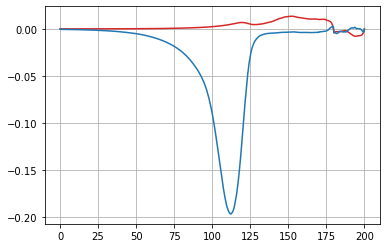

[ 6.97891929  7.19868455  7.41694852  7.1105387  14.46009996 10.88786778
  6.84939938  0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.        ]
-------  20 0.4500000000000001 0.4750000000000002
set cost params:  0.0004858186059431078 0.0 1.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  8.069615331382344
Gradient descend method:  None
RUN  1 , total integrated cost =  8.011761059564963
RUN  2 , total integrated cost =  9.433775457726284
RUN  3 , total integrated cost =  8.431949485294446
RUN  4 , total integrated cost =  7.810641066408987
RUN  5 , total integrated cost =  7.64529208746903
RUN  6 , total integrated cost =  7.6820639135024695
RUN  7 , total integrated cost =  7.597714204279178
RUN  8 , total integrated cost =  8.200431704350343
RUN  9 , total integrated cost =  7.795176783163046
RUN  10 , total integrated cost

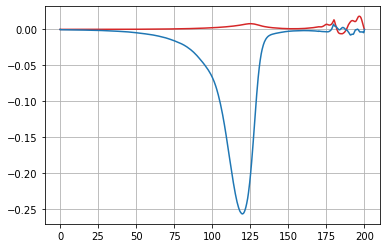

[ 8.06961533  8.01176106  9.43377546  8.43194949  7.81064107  7.64529209
  7.68206391  7.5977142   8.2004317   7.79517678  7.6349279   7.67700451
  8.03409833  7.49435557  7.85713478  7.49606665  7.95117503 13.76294915
  7.57910055  7.83959346  0.          0.          0.          0.
  0.        ]
-------  30 0.4250000000000001 0.5250000000000002
-------  40 0.5250000000000001 0.5500000000000003
set cost params:  0.000542705622498159 0.0 1.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  6.351294273406019
Gradient descend method:  None
RUN  1 , total integrated cost =  6.1750392647398265
RUN  2 , total integrated cost =  5.579565895797169
RUN  3 , total integrated cost =  5.900117949932504
RUN  4 , total integrated cost =  9.667796779079742
RUN  5 , total integrated cost =  5.63619732419195
RUN  6 , total integrated cost =  6.030335332064617
RUN  7 , total integrated cost =  6.33281465130143
RUN  8 , total integrated cost =  6.5657612634922495
RUN  9 , total int

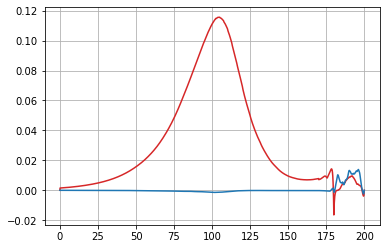

[6.35129427 6.17503926 5.5795659  5.90011795 9.66779678 5.63619732
 6.03033533 6.33281465 6.56576126 6.17950626 5.97628264 9.82991764
 6.06658086 5.90160568 0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.        ]
-------  50 0.47500000000000014 0.6000000000000003
set cost params:  0.0005164616969688605 0.0 1.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  9.227806054820103
Gradient descend method:  None
RUN  1 , total integrated cost =  9.168016767539868
RUN  2 , total integrated cost =  9.057041601198634
RUN  3 , total integrated cost =  9.281973498322808
RUN  4 , total integrated cost =  8.81603096519069
RUN  5 , total integrated cost =  8.894818656639728
RUN  6 , total integrated cost =  8.529147308010998
RUN  7 , total integrated cost =  12.391390504171284
no cost improvement
RUN  8 , total integrated cost =  8.874231908224674
RUN  9 , total integrated cost =  14.837447792750787
RUN  10 , total integrated

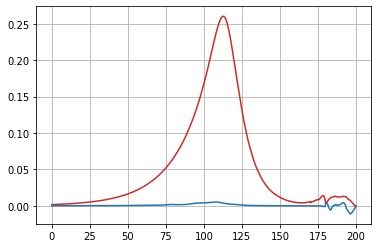

[ 9.22780605  9.16801677  9.0570416   9.2819735   8.81603097  8.89481866
  8.52914731 12.3913905   8.87423191 14.83744779  8.90362009  9.35141899
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.        ]
-------  60 0.5500000000000003 0.6250000000000003
set cost params:  0.0005579544114946055 0.0 1.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  5.630012751011253
Gradient descend method:  None
RUN  1 , total integrated cost =  6.2232354530427445
RUN  2 , total integrated cost =  5.673519167380665
RUN  3 , total integrated cost =  5.580886398106526
RUN  4 , total integrated cost =  5.69467731384727
RUN  5 , total integrated cost =  5.792607724321219
RUN  6 , total integrated cost =  5.741788667822273
RUN  7 , total integrated cost =  5.464367143041464
RUN  8 , total integrated cost =  5.5571563762614
RUN  9 , total integrated cost =  10.063089291354835
no cost improvement
RUN 

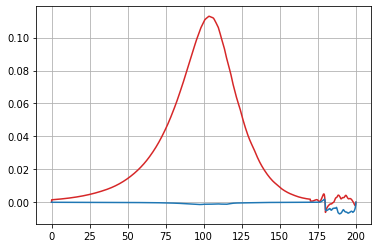

[ 5.63001275  6.22323545  5.67351917  5.5808864   5.69467731  5.79260772
  5.74178867  5.46436714  5.55715638 10.06308929  9.48086297  9.42156701
  8.41852075  9.64834993  5.95823481  5.82311117  0.          0.
  0.          0.          0.          0.          0.          0.
  0.        ]


In [59]:
for i in i_range:
    
    aln.params.ext_exc_current = exc[i] * 5.
    aln.params.ext_inh_current = inh[i] * 5.

    print("------- ", i, exc[i], inh[i])
    if i in stateswitch_i:
        continue
    
    aln.params.duration = dur
    init_control = aln.getZeroControl()
    
    if np.amax(np.abs(init_control_noisefree[i][0,0,:])) > np.amax(np.abs(init_control_noisefree[i][0,1,:])):
        c_ind = 0
    else:
        c_ind = 1
    
    for t_ in range(init_control_noisefree[i].shape[2]):
        if ( np.abs(init_control_noisefree[i][0,c_ind,t_-100+int( (trans_time * dur / aln.params.dt) )])
             < np.abs(init_control_noisefree[i][0,c_ind,t_]) ):
            break
    init_control[:,c_ind,1:1-100+int( (trans_time * dur / aln.params.dt) )] = ( 
        factor[i] * init_control_noisefree[i][:,c_ind,t_:t_-100+int( (trans_time * dur / aln.params.dt) )] )
    
    setinit(initVars[i], aln)
    
    cost.setParams(w_p[i], w_e, w_s)

    bestControl[i], bestState[i], cost_[i], runtime, grad, phi, costnode[i], total_cost_mean_std = aln.A1(
        init_control, target[i], c_scheme, u_mat, u_scheme, max_iteration_ = max_it,
        tolerance_ = tol, startStep_ = start_step, max_control_ = max_cntrl, min_control_ = min_cntrl,
        t_sim_ = dur, t_sim_pre_ = dur_pre, t_sim_post_ = dur_post, CGVar = None,
        control_variables_ = [0,1], prec_variables_ = prec_vars, transition_time_ = trans_time,
        noise_real=noise_realizations, init_params = initVars[i], method='M3')

    control_init = bestControl[i][:,:,100:-100]

    plt.plot(np.arange(0,dur+aln.params.dt,aln.params.dt), control_init[0,0,:]/5., color=exc_red)
    plt.plot(np.arange(0,dur+aln.params.dt,aln.params.dt), control_init[0,1,:]/5., color=inh_blue)
    plt.show()

    control_nf_1[i] = bestControl[i]
    cost_minind = 0
    cost_nf_1[i] = np.zeros(( max_it ))
    for k in range(len(cost_nf_1[i])):
        cost_nf_1[i][k] = np.mean(cost_[i][:,k])
        if cost_nf_1[i][k] > 0.:
            cost_minind = k

    print(cost_nf_1[i])
    
    with open(file_nf_1,'wb') as f:
        pickle.dump([control_nf_1, control_nf_1], f)
    

In [240]:
if os.path.isfile(file_nf_1) :
    print("file found")
    
    with open(file_nf_1,'rb') as f:
        load_array = pickle.load(f)

    control_ = load_array[0]
    cost_ = load_array[1]

for i in i_range:
    if i in stateswitch_i:
        continue
    control_nf_1[i] = control_[i].copy()

file found


-------  60 0.5500000000000003 0.6250000000000003
repeat  0
set cost params:  0.0005584235003587904 0.0 1.0
interpolate adjoint :  True True True


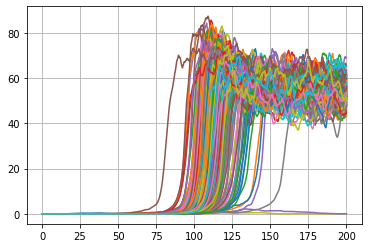

RUN  0 , total integrated cost =  9.197555391189715
Gradient descend method:  None
RUN  1 , total integrated cost =  4.744234620101825
RUN  2 , total integrated cost =  4.6074462512840375
RUN  3 , total integrated cost =  4.688960871853176


TypeError: can't unbox a <class 'numba.typed.typedlist.List'> as a <NULL>

In [355]:
for i in i_range:
    
    aln.params.ext_exc_current = exc[i] * 5.
    aln.params.ext_inh_current = inh[i] * 5.

    print("------- ", i, exc[i], inh[i])
    if i in stateswitch_i:
        continue
    
    for k in range(repeat):
        print("repeat ", k)
    
        control_list = []
        cost_list = []
        aln.params.duration = dur

        cost.setParams(w_p[i], w_e, w_s)
        control_init = control_nf_1[i][:,:,100:-100]
        setinit(initVars[i], aln)

        bestControl[i], bestState[i], cost_[i], runtime, grad, phi, costnode[i], total_cost_mean_std = aln.A1(
            control_init, target[i], c_scheme, u_mat, u_scheme, max_iteration_ = max_it,
            tolerance_ = tol, startStep_ = start_step, max_control_ = max_cntrl, min_control_ = min_cntrl,
            t_sim_ = dur, t_sim_pre_ = dur_pre, t_sim_post_ = dur_post, CGVar = None,
            control_variables_ = [0,1], prec_variables_ = prec_vars, transition_time_ = trans_time,
            noise_real=noise_realizations, init_params = initVars[i], method='M3')

        control_init = bestControl[i][:,:,100:-100]
        setinit(initVars[i], aln)

        plt.plot(np.arange(0,dur+aln.params.dt,aln.params.dt), control_init[0,0,:]/5., color=exc_red)
        plt.plot(np.arange(0,dur+aln.params.dt,aln.params.dt), control_init[0,1,:]/5., color=inh_blue)
        plt.show()

        control_nf_1[i] = bestControl[i]
        cost_minind = 0
        cost_nf_1[i] = np.zeros(( max_it ))
        for k in range(len(cost_nf_1[i])):
            cost_nf_1[i][k] = np.mean(cost_[i][:,k])
            if cost_nf_1[i][k] > 0.:
                cost_minind = k

        with open(file_nf_1,'wb') as f:
            pickle.dump([control_nf_1, cost_nf_1], f)

In [60]:
for i in i_range:
    
    aln.params.ext_exc_current = exc[i] * 5.
    aln.params.ext_inh_current = inh[i] * 5.

    print("------- ", i, exc[i], inh[i])
    if i in stateswitch_i:
        continue
    
    aln.params.duration = dur
    init_control = aln.getZeroControl()           
    init_control[:,:,:] = control_nf_1[i][:,:,100:-100]
    
    target_ = target[i].copy()
    target_[0,0,:int(trans_time * dur / aln.params.dt)] = -1000
    target_[0,1,:int(trans_time * dur / aln.params.dt)] = -1000
    
    cost_nf_1_final[i] = np.zeros(( noise_realizations_final ))
    
    for n_ in range(noise_realizations_final):
    
        setinit(initVars[i], aln)
        state_ = fo.updateState(aln, init_control)
        cost_nf_1_final[i][n_] += cost.numba_cost_precision_int(1,T,dt,w_p[i],state_, target_, list(prec_vars) )
        cost_nf_1_final[i][n_] += cost.numba_cost_sparsity_int(1, 6, T, w_s, dt, init_control)
    
    print(np.mean(cost_nf_1_final[i]))

-------  10 0.4250000000000001 0.42500000000000016
8.094442544850637
-------  20 0.4500000000000001 0.4750000000000002
8.21729468851713
-------  30 0.4250000000000001 0.5250000000000002
-------  40 0.5250000000000001 0.5500000000000003
8.702580325067375
-------  50 0.47500000000000014 0.6000000000000003
10.954841115020836
-------  60 0.5500000000000003 0.6250000000000003
8.015045451971524


In [61]:
for i in i_range:
    
    aln.params.ext_exc_current = exc[i] * 5.
    aln.params.ext_inh_current = inh[i] * 5.

    print("------- ", i, exc[i], inh[i])
    if i in stateswitch_i:
        continue
    
    aln.params.duration = dur
    init_control = aln.getZeroControl()
    init_control[:,0,500:1000] = 1.
    
    rect_E[i] = init_control
    
    target_ = target[i].copy()
    target_[0,0,:int(trans_time * dur / aln.params.dt)] = -1000
    target_[0,1,:int(trans_time * dur / aln.params.dt)] = -1000
    
    cost_rect_E_final[i] = np.zeros(( noise_realizations_final ))
    
    for n_ in range(noise_realizations_final):
    
        setinit(initVars[i], aln)
        aln.run(control=init_control)
        state_ = fo.updateState(aln, init_control)
        cost_rect_E_final[i][n_] = cost.f_int(init_control.shape[0], init_control.shape[1],
                        init_control.shape[2], aln.params.dt, state_, target_, init_control, w_p[i], w_e, w_s)
    
    print(np.mean(cost_rect_E_final[i]))

-------  10 0.4250000000000001 0.42500000000000016
11.147229303483353
-------  20 0.4500000000000001 0.4750000000000002
9.68250488326654
-------  30 0.4250000000000001 0.5250000000000002
-------  40 0.5250000000000001 0.5500000000000003
9.402852755114786
-------  50 0.47500000000000014 0.6000000000000003
10.023407478179976
-------  60 0.5500000000000003 0.6250000000000003
9.327828930730062


In [62]:
for i in i_range:
    
    aln.params.ext_exc_current = exc[i] * 5.
    aln.params.ext_inh_current = inh[i] * 5.

    print("------- ", i, exc[i], inh[i])
    if i in stateswitch_i:
        continue
    
    aln.params.duration = dur
    init_control = aln.getZeroControl()
    init_control[:,1,500:1000] = -1.

    rect_I[i] = init_control
    
    target_ = target[i].copy()
    target_[0,0,:int(trans_time * dur / aln.params.dt)] = -1000
    target_[0,1,:int(trans_time * dur / aln.params.dt)] = -1000
    
    cost_rect_I_final[i] = np.zeros(( noise_realizations_final ))
    
    for n_ in range(noise_realizations_final):
    
        setinit(initVars[i], aln)
        state_ = fo.updateState(aln, init_control)
        cost_rect_I_final[i][n_] = cost.f_int(init_control.shape[0], init_control.shape[1],
                        init_control.shape[2], aln.params.dt, state_, target_, init_control, w_p[i], w_e, w_s)
    
    print(np.mean(cost_rect_I_final[i]))

-------  10 0.4250000000000001 0.42500000000000016
10.899540109984729
-------  20 0.4500000000000001 0.4750000000000002
9.665918979064417
-------  30 0.4250000000000001 0.5250000000000002
-------  40 0.5250000000000001 0.5500000000000003
9.415555229742576
-------  50 0.47500000000000014 0.6000000000000003
254.14450105248602
-------  60 0.5500000000000003 0.6250000000000003
14.057091740812687


In [103]:
title_ = [''] * len(exc)
fs_ = 16
for i in i_range:
    title_[i] = 'Point {:d}'.format(i)

E_I_init_10.png


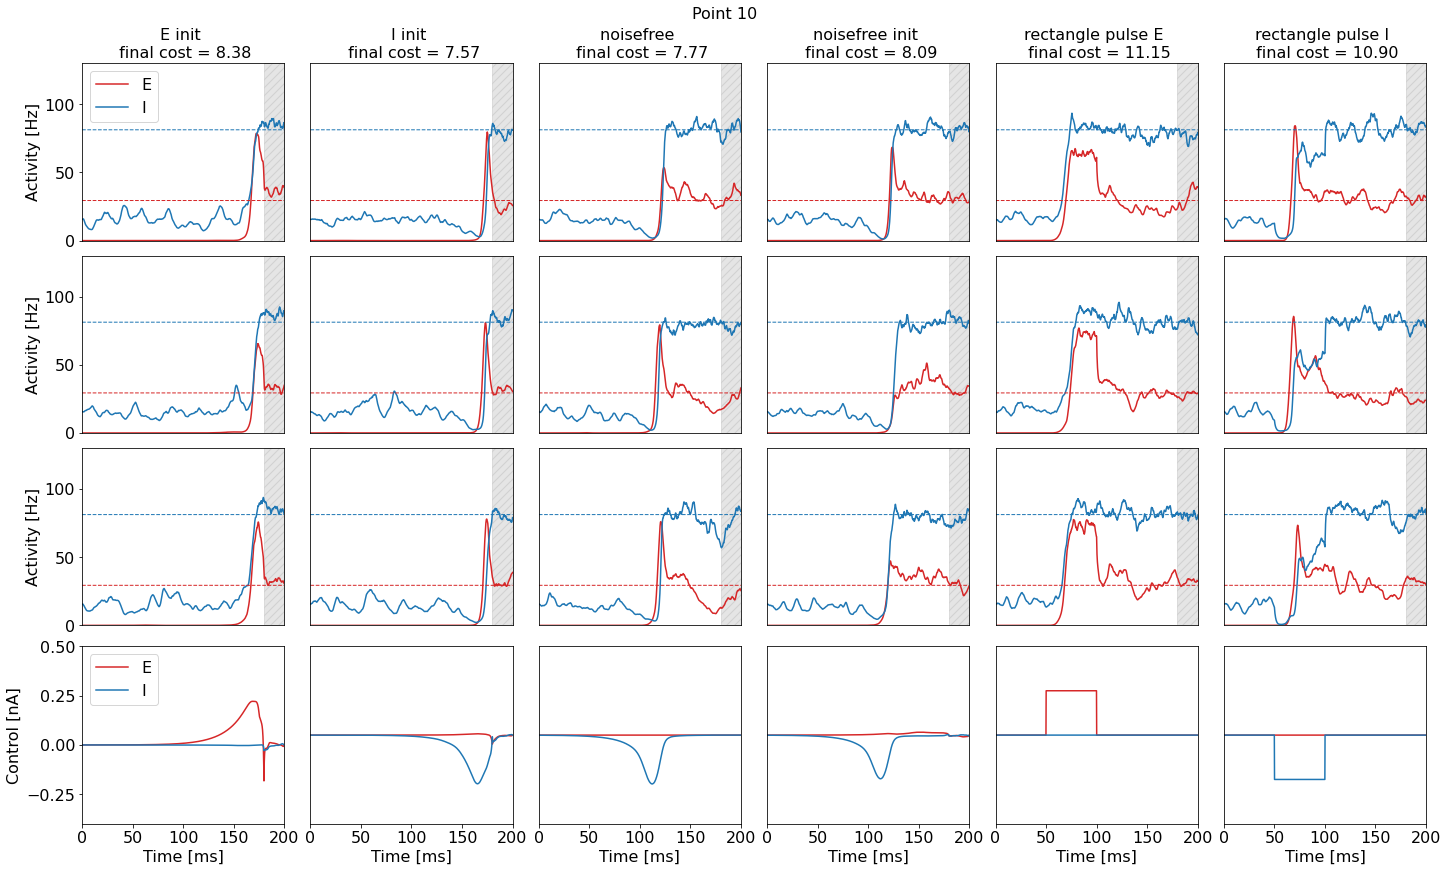

E_I_init_20.png


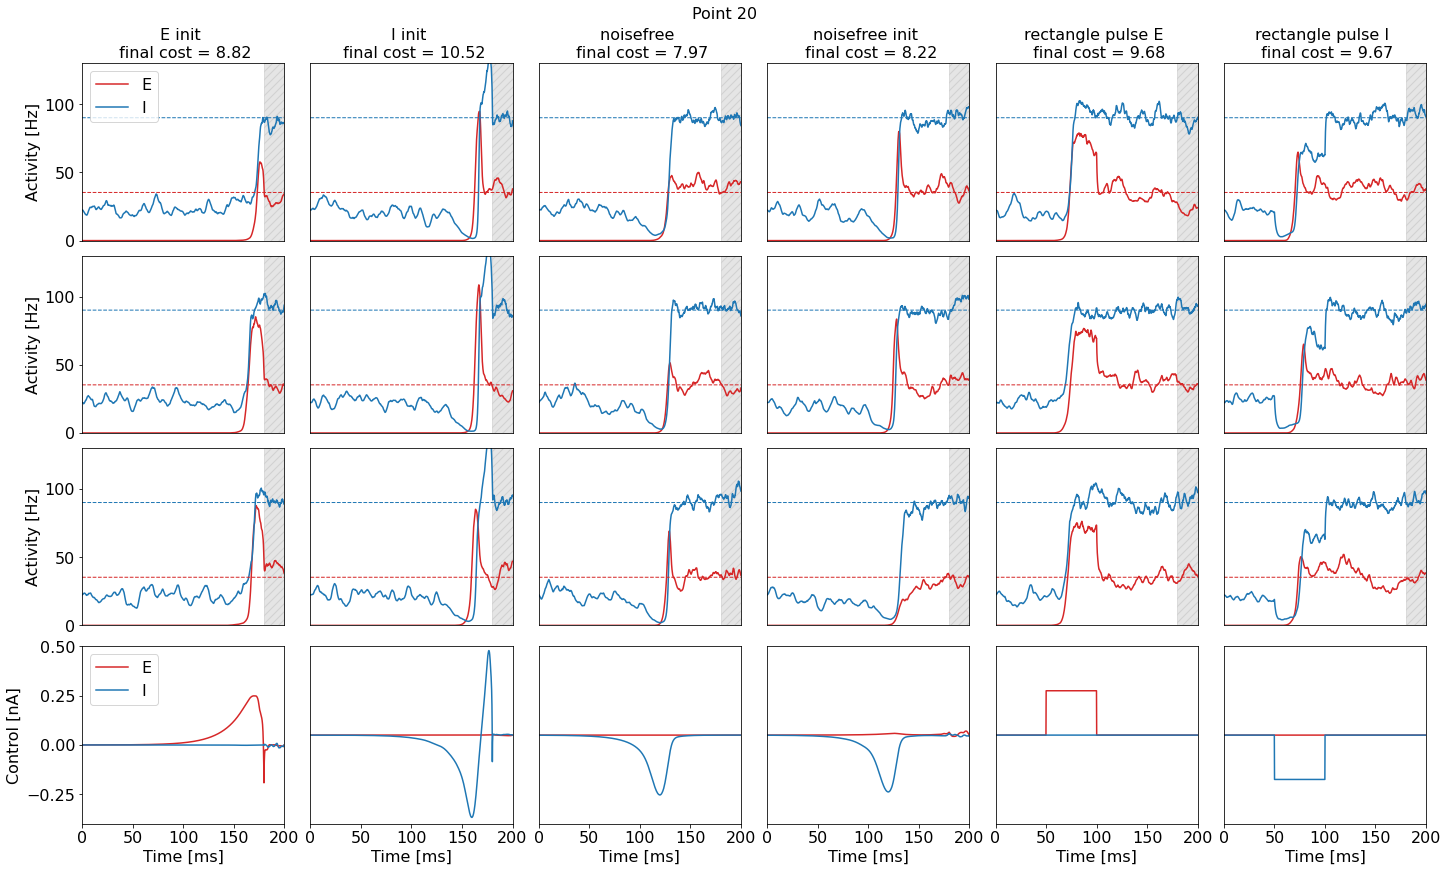

E_I_init_30.png
E_I_init_40.png


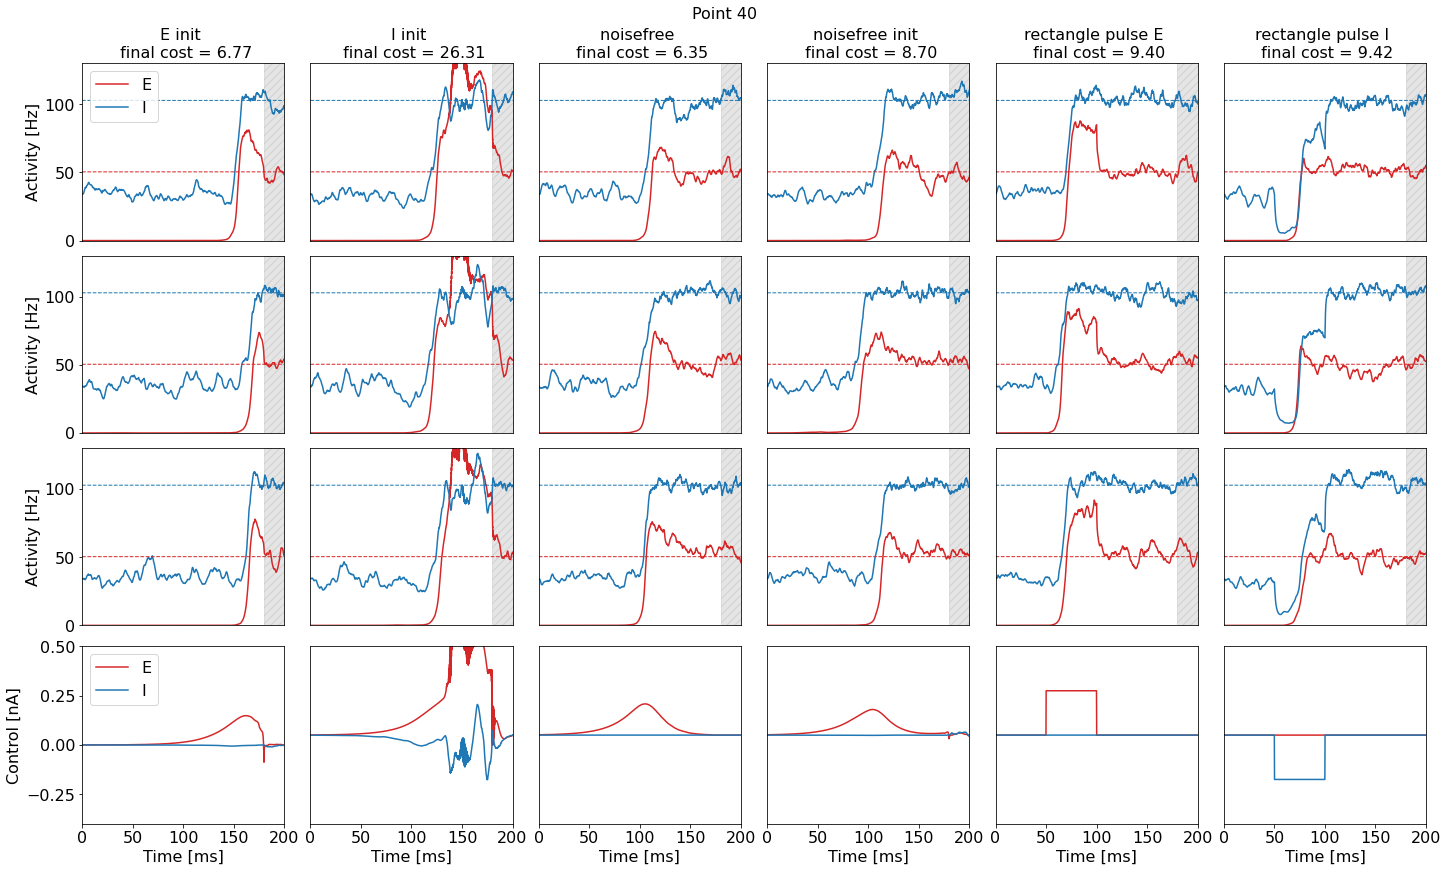

E_I_init_50.png


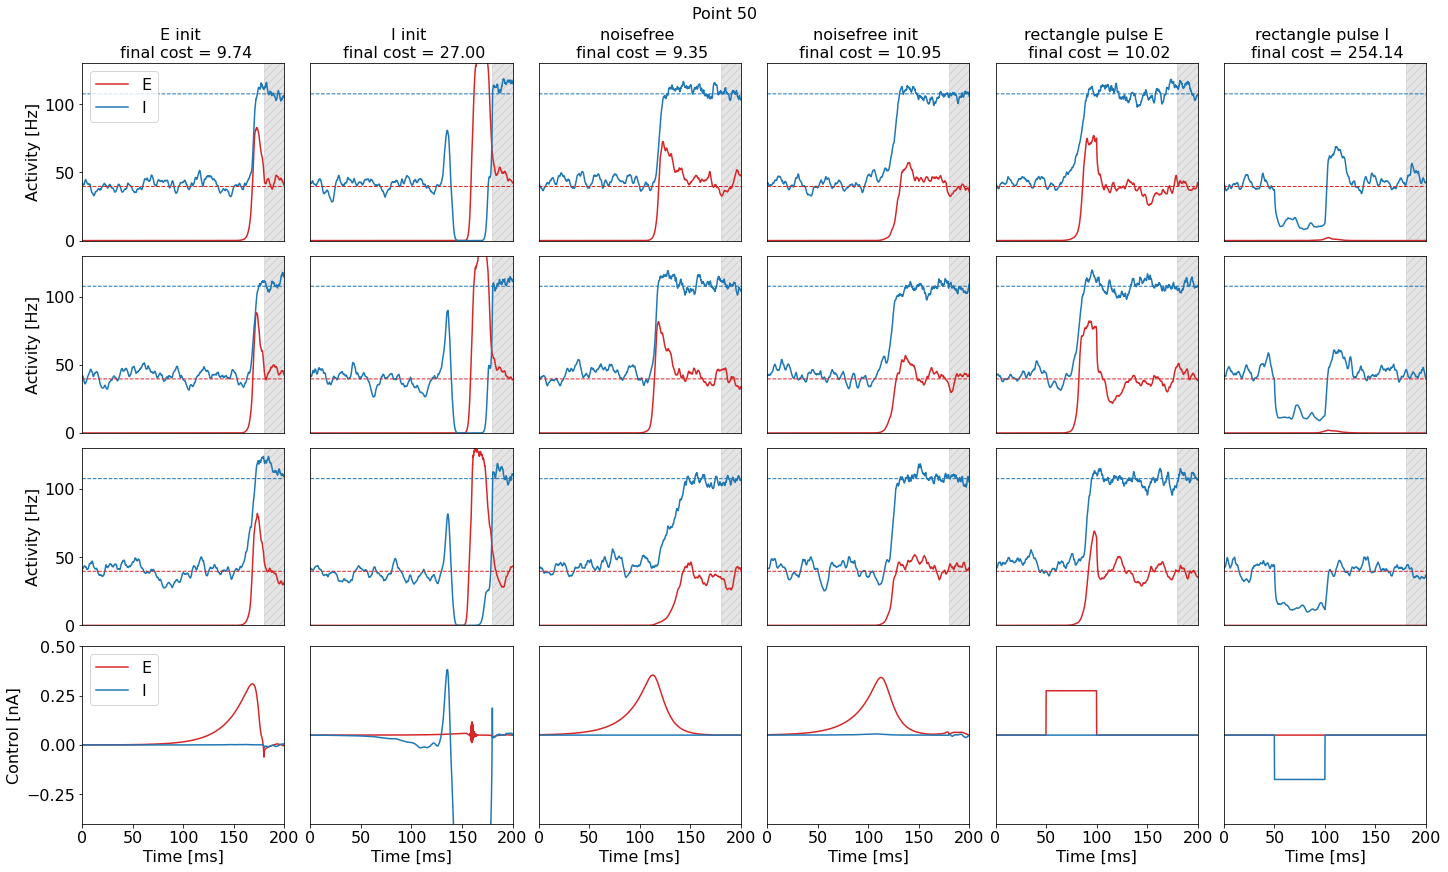

E_I_init_60.png


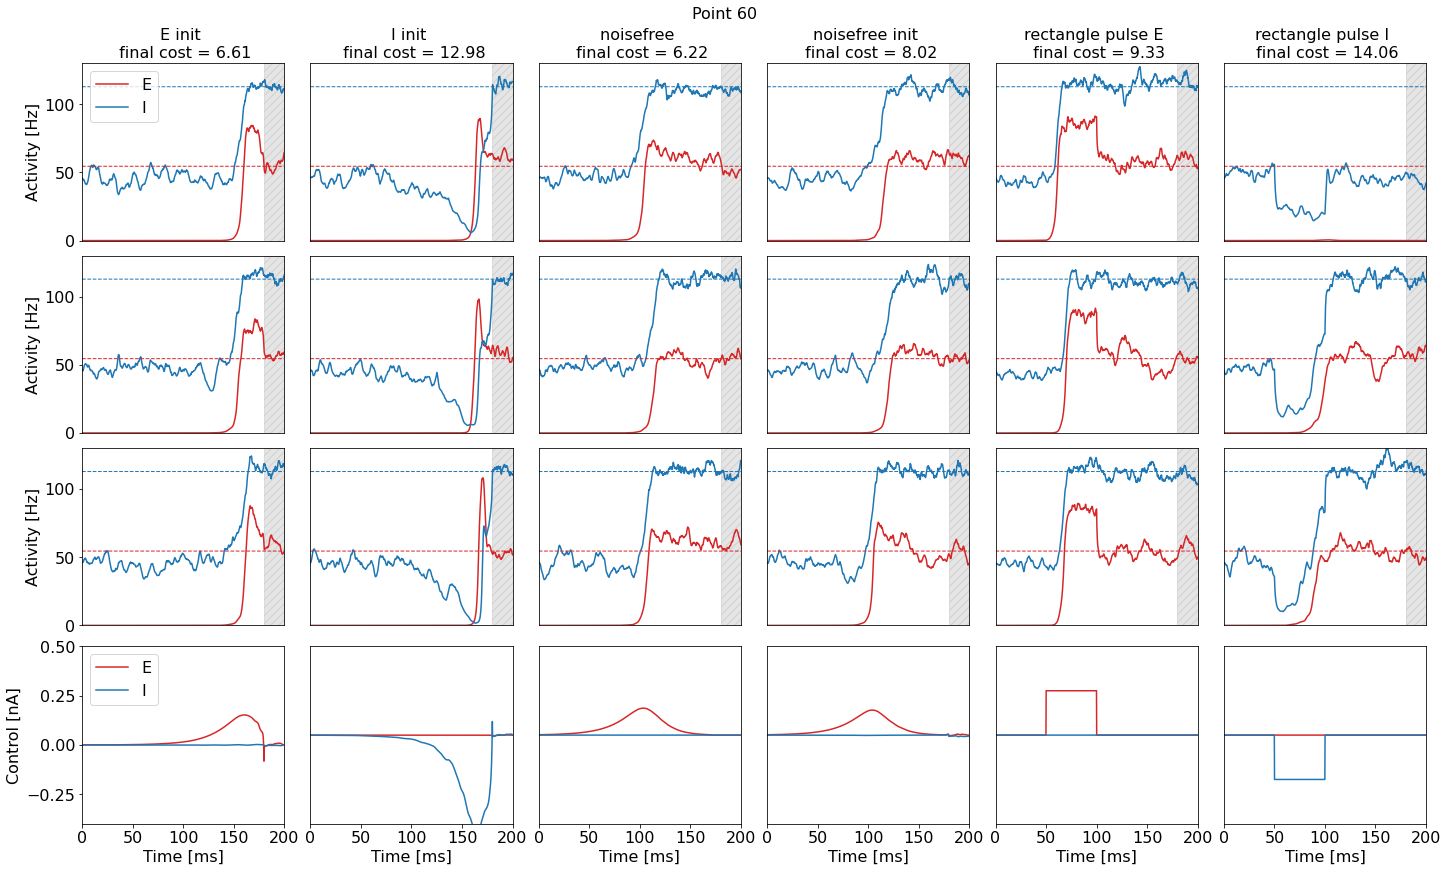

In [77]:
for i in i_range:

    aln.params.ext_exc_current = exc[i] * 5.
    aln.params.ext_inh_current = inh[i] * 5.
    
    filename_ = str('E_I_init_' + title_[i][-2:] + '.png' )
    print(filename_)
    
    if i in stateswitch_i:
        continue
        
    aln.params.duration = dur
    aln.run(control=control_E[i][:,:,100:-100])

    fig, ax = plt.subplots(4, 6, figsize=(20,12), constrained_layout=True, facecolor='white')
    fig.suptitle(title_[i], fontsize=fs_)

    for k in range(6):
        
        if k == 0:
            control_ = control_E[i][:,:,100:-100]
            ax[0,k].set_title('E init \n final cost = {:.2f}'.format(np.mean(cost_E_final[i])), fontsize=fs_)
        elif k == 1:
            control_ = control_I[i][:,:,100:-100]
            ax[0,k].set_title('I init \n final cost = {:.2f}'.format(np.mean(cost_I_final[i])), fontsize=fs_)
        elif k == 2:
            control_ = control_nf[i]
            ax[0,k].set_title('noisefree \n final cost = {:.2f}'.format(np.mean(cost_nf_final[i])), fontsize=fs_)
        elif k == 3:
            control_ = control_nf_1[i][:,:,100:-100]
            ax[0,k].set_title('noisefree init \n final cost = {:.2f}'.format(np.mean(cost_nf_1_final[i])), fontsize=fs_)
        elif k == 4:
            control_ = rect_E[i]
            ax[0,k].set_title('rectangle pulse E \n final cost = {:.2f}'.format(np.mean(cost_rect_E_final[i])), fontsize=fs_)
        elif k == 5:
            control_ = rect_I[i]
            ax[0,k].set_title('rectangle pulse I \n final cost = {:.2f}'.format(np.mean(cost_rect_I_final[i])), fontsize=fs_)

        ax[3,k].plot(aln.t, control_[0,0,:]/5., color=exc_red, label='E')
        ax[3,k].plot(aln.t, control_[0,1,:]/5., color=inh_blue, label='I')

        ax[3,k].set_ylim(-0.4, 0.4)
        ax[3,k].set_xlim(0,dur)
        ax[3,k].set_xlabel('Time [ms]', fontsize=fs_)
        ax[3,k].tick_params(axis='y', labelsize=fs_)
        ax[3,k].tick_params(axis='x', labelsize=fs_)
        ax[3,k].grid(False)

        if k == 0:
            ax[3,k].set_yticks(np.arange(-0.25, 0.55, 0.25))
            ax[3,k].set_ylabel('Control [nA]', fontsize=fs_)
            ax[3,k].tick_params(axis='y', labelsize=fs_)

        else:
            ax[3,k].set_yticks([])

        # realization 1
        for j in range(3):
            setinit(initVars[i], aln)
            aln.run(control=control_)
            ax[j,k].plot(aln.t, aln.rates_exc[0,:], color=exc_red, label='E')
            ax[j,k].plot(aln.t, aln.rates_inh[0,:], color=inh_blue, label='I')
            ax[j,k].plot(aln.t, target[i][0,0,:], color=exc_red, linestyle='--', linewidth=1)
            ax[j,k].plot(aln.t, target[i][0,1,:], color=inh_blue, linestyle='--', linewidth=1)
            ax[j,k].set_xticks([])
            ax[j,k].grid(False)

            ax[j,k].set_ylim(0,130)
            ax[j,k].set_xlim(0,dur)
            if k == 0:
                ax[j,k].set_ylabel('Activity [Hz]', fontsize=fs_)
                ax[j,k].tick_params(axis='y', labelsize=fs_)
            else:
                ax[j,k].set_yticks([])
            ax[j,k].axvspan( dur*trans_time, dur, facecolor='grey', alpha=0.2, zorder=-1, hatch='///', edgecolor = 'grey')


    ax[0,0].legend(fontsize=fs_, loc='upper left')
    ax[3,0].legend(fontsize=fs_, loc='upper left')
    
    fig.savefig( os.path.join(final_folder_plots,filename_), dpi=fig.dpi, facecolor='white')
    plt.show()

E_I_init_10_cost_hist.png


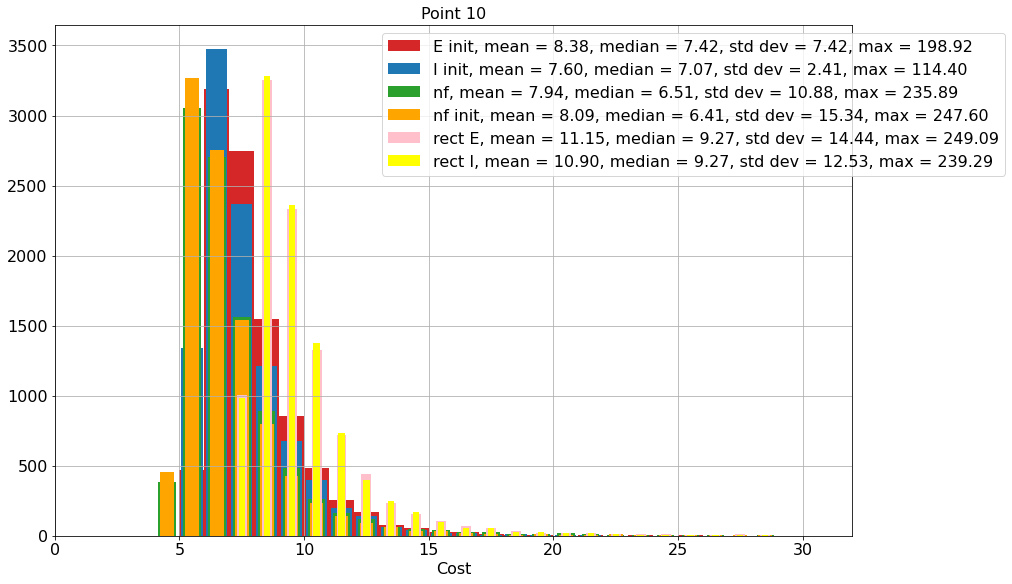

E_I_init_20_cost_hist.png


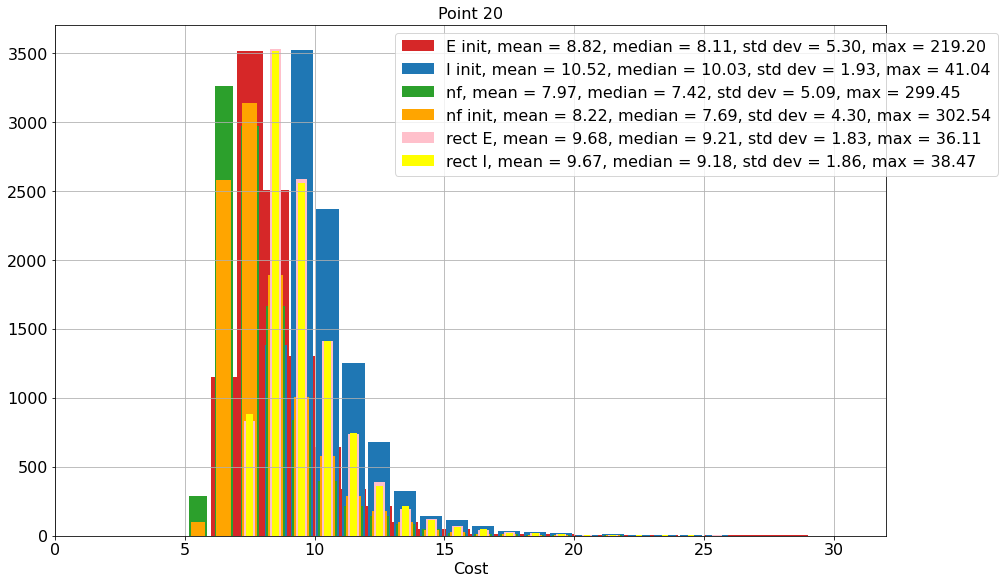

E_I_init_40_cost_hist.png


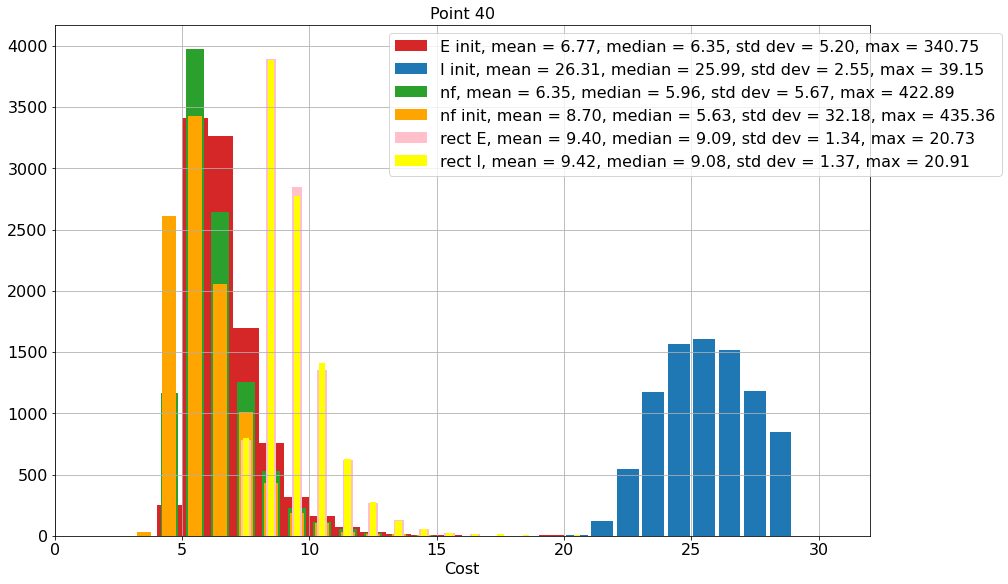

E_I_init_50_cost_hist.png


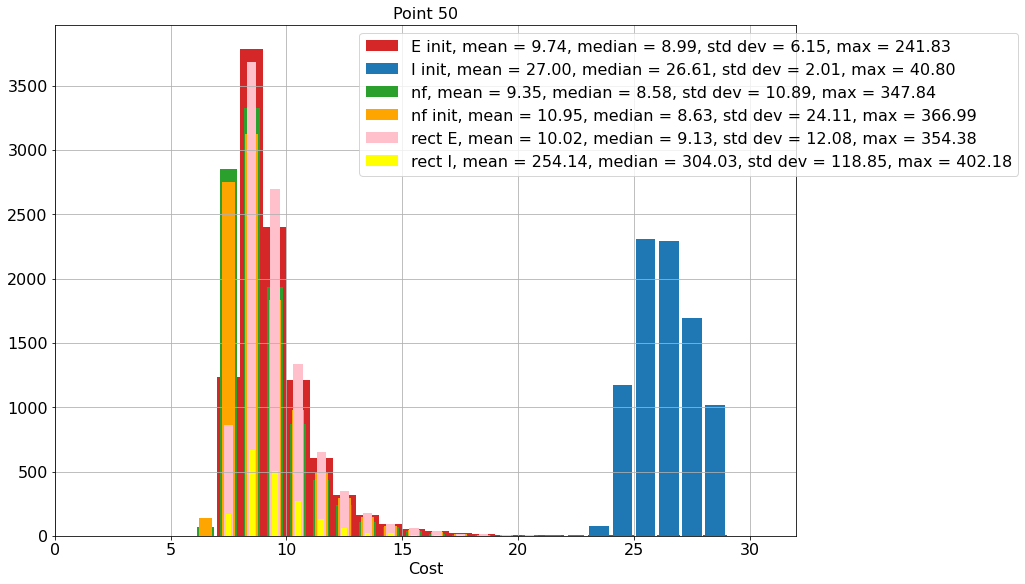

E_I_init_60_cost_hist.png


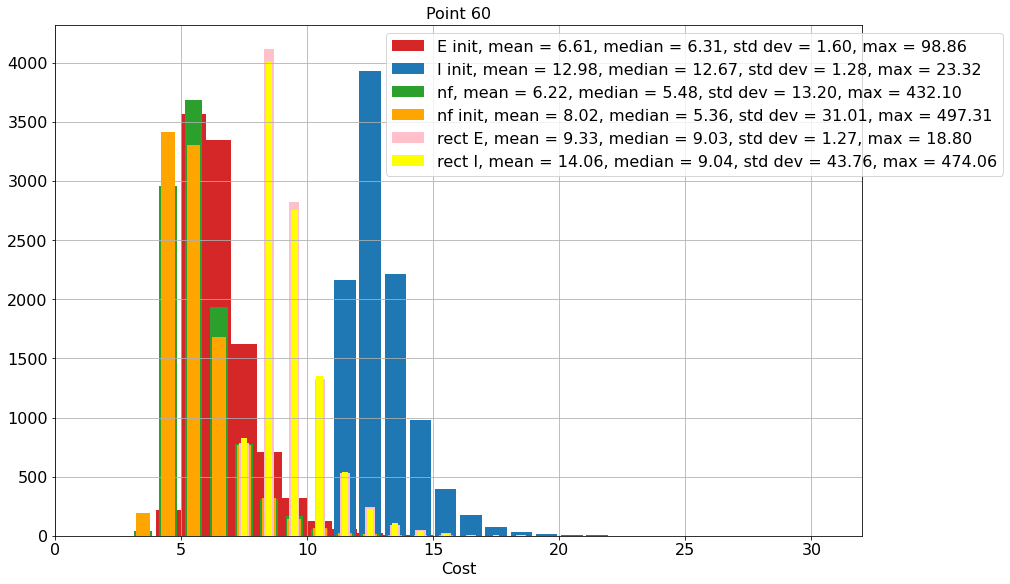

In [65]:
hist_binwidth = 1
hist_max = 30
bins = []
for k in np.arange(0,hist_max, hist_binwidth):
    bins.append(k)
    #bins.append(100)
    #bins.append(1000)

for i in i_range:
    
    if i in stateswitch_i:
        continue

    l_ = ['','','','', '', '']
    init_ = ['E init', 'I init', 'nf', 'nf init', 'rect E', 'rect I']
    mean_ = [np.mean(cost_E_final[i]), np.mean(cost_I_final[i]),
             np.mean(cost_nf_final[i]), np.mean(cost_nf_1_final[i]),
            np.mean(cost_rect_E_final[i]), np.mean(cost_rect_I_final[i])]
    med_ = [np.median(cost_E_final[i]), np.median(cost_I_final[i]),
            np.median(cost_nf_final[i]), np.median(cost_nf_1_final[i]),
            np.median(cost_rect_E_final[i]), np.median(cost_rect_I_final[i])]
    std_ = [np.std(cost_E_final[i]), np.std(cost_I_final[i]),
            np.std(cost_nf_final[i]), np.std(cost_nf_1_final[i]),
            np.std(cost_rect_E_final[i]), np.std(cost_rect_I_final[i])]
    max_ = [np.amax(cost_E_final[i]), np.amax(cost_I_final[i]),
            np.amax(cost_nf_final[i]), np.amax(cost_nf_1_final[i]),
            np.amax(cost_rect_E_final[i]), np.amax(cost_rect_I_final[i])]

    for k in range(6):
        l_[k] = str( init_[k] + ', mean = {:.2f}, median = {:.2f}, std dev = {:.2f}, max = {:.2f}'.format(
            mean_[k], med_[k], std_[k], max_[k]) )

    plt.figure(figsize=(14,8), constrained_layout=True)
    kwargs = dict(histtype='barstacked', bins=bins, linewidth=2)

    plt.hist(cost_E_final[i], **kwargs, color=exc_red, label=l_[0], rwidth=1.)
    plt.hist(cost_I_final[i], **kwargs, color=inh_blue, label=l_[1], rwidth=0.85)
    plt.hist(cost_nf_final[i], **kwargs, color=green, label=l_[2], rwidth=0.7)
    plt.hist(cost_nf_1_final[i], **kwargs, color='orange', label=l_[3], rwidth=.55)
    plt.hist(cost_rect_E_final[i], **kwargs, color='pink', label=l_[4], rwidth=0.4)
    plt.hist(cost_rect_I_final[i], **kwargs, color='yellow', label=l_[5], rwidth=.25)

    plt.title(title_[i], fontsize=fs_)
    plt.xlabel('Cost', fontsize=fs_)
    plt.xlim(0,hist_max+2)
    plt.legend(fontsize=fs_, bbox_to_anchor=(0.4, 1.0))
    plt.tick_params(axis='y', labelsize=fs_)
    plt.tick_params(axis='x', labelsize=fs_)

    filename_ = str('E_I_init_' + title_[i][-2:] + '_cost_hist.png' )
    print(filename_)
    plt.savefig( os.path.join(final_folder_plots,filename_), dpi=fig.dpi, facecolor='white')
    plt.show()


noisefree_init_ 0.png
1.0
noisefree_init_ 5.png
1.0
noisefree_init_10.png
1.7250000000000005
944


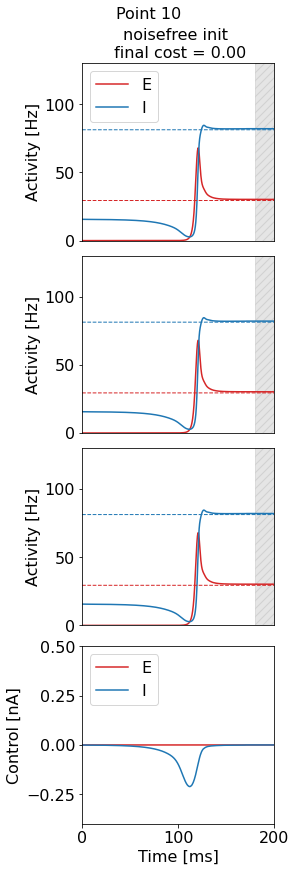

noisefree_init_15.png
0.9
966


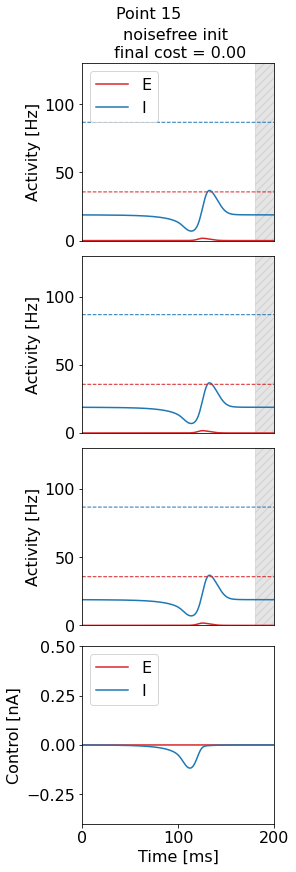

noisefree_init_20.png
1.025
890


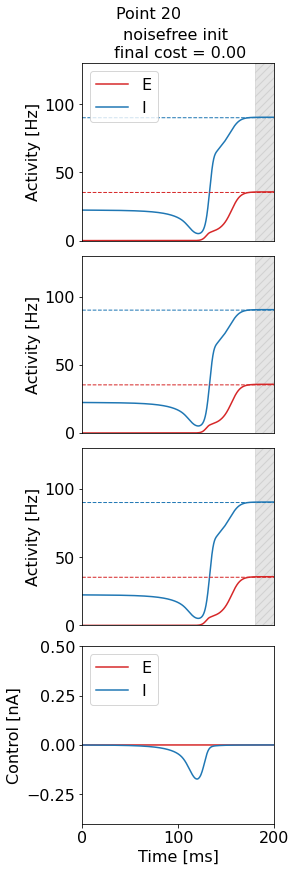

noisefree_init_25.png
0.9
1520


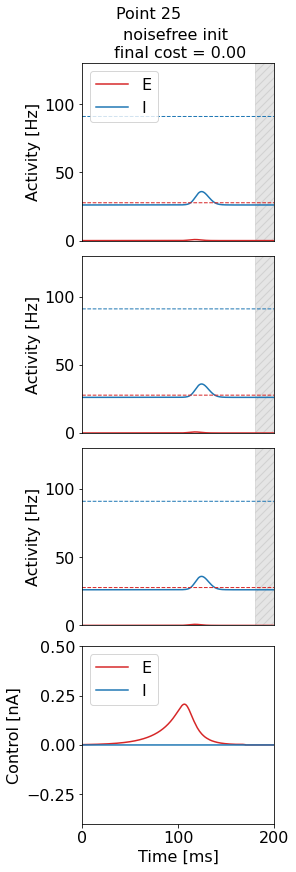

noisefree_init_30.png
1.0
noisefree_init_35.png
0.9
1604


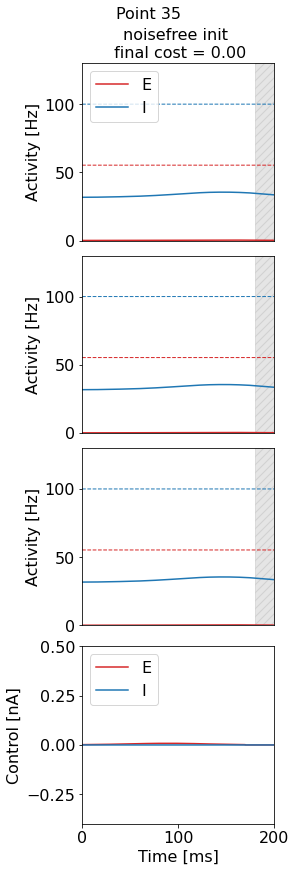

noisefree_init_40.png
1.025
1315


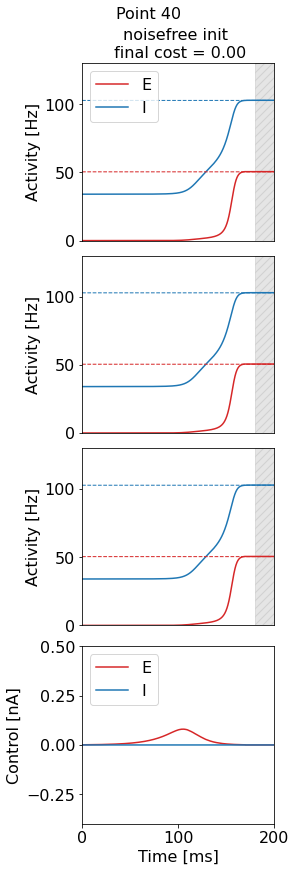

noisefree_init_45.png
0.9
1389


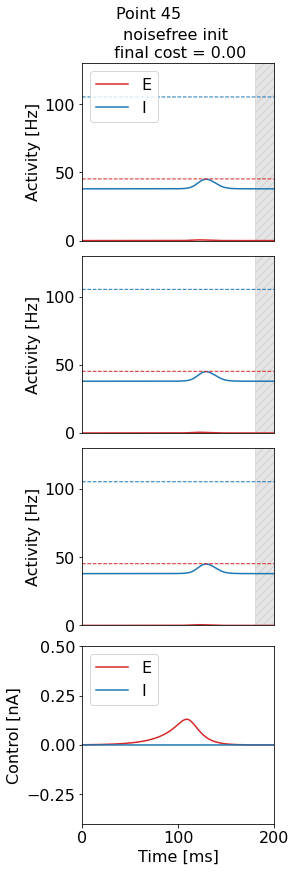

noisefree_init_50.png
1.025
1345


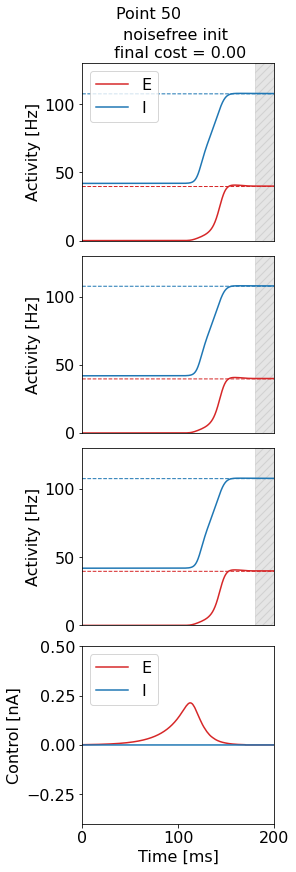

noisefree_init_55.png
1.0
noisefree_init_60.png
1.025
1352


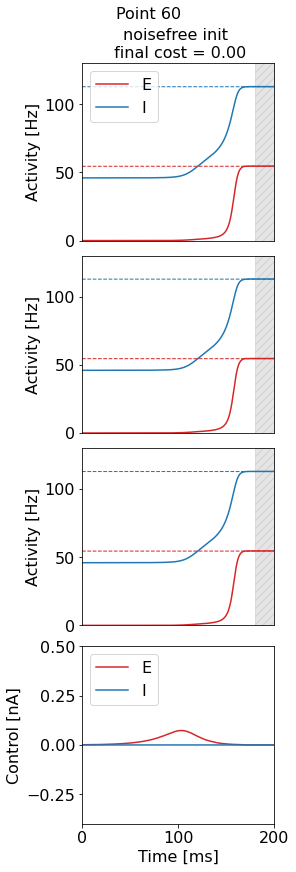

noisefree_init_65.png
0.9
1419


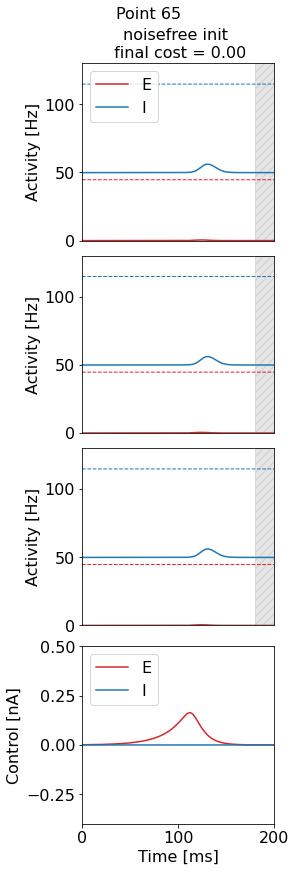

noisefree_init_70.png
0.9
1538


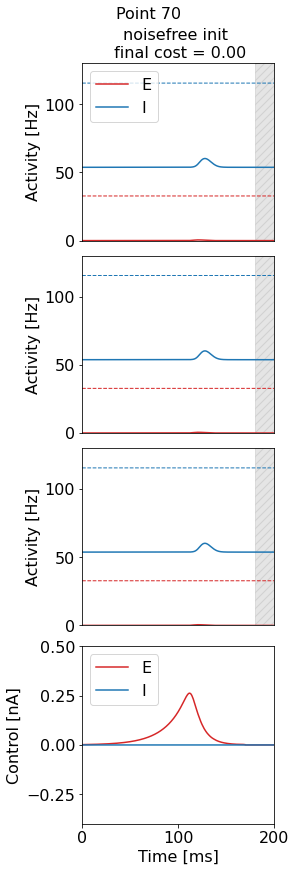

noisefree_init_75.png
0.9
1561


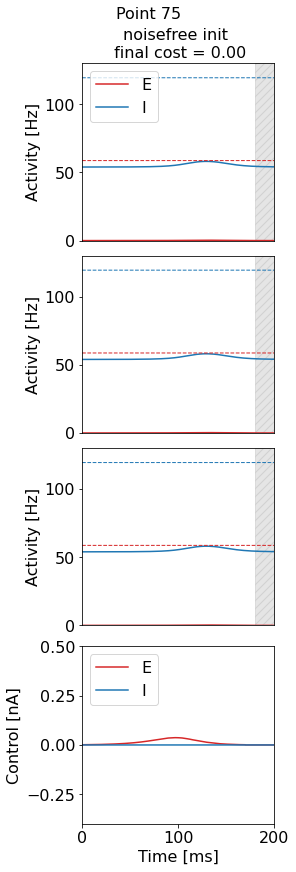

noisefree_init_80.png
0.9
1392


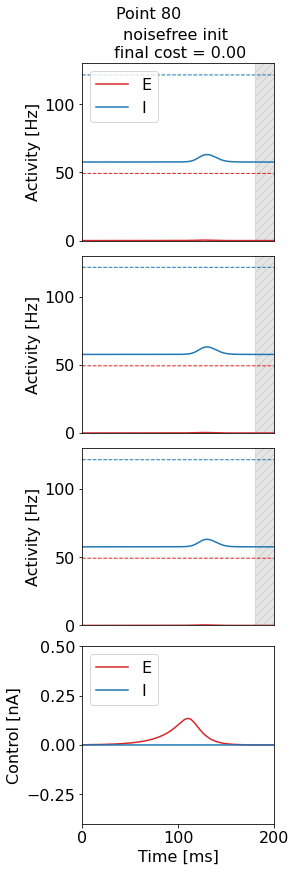

In [115]:
for i in i_range:

    aln.params.ext_exc_current = exc[i] * 5.
    aln.params.ext_inh_current = inh[i] * 5.
    
    filename_ = str('noisefree_init_' + title_[i][-2:] + '.png' )
    print(filename_)
    
    print(factor[i])
    
    if i in stateswitch_i:
        continue
        
    t_ = int(t_array[i])
    print(t_)
        
    aln.params.duration = dur
    init_control = aln.getZeroControl()
    init_control[:,:,1:1-100+int( (trans_time * dur / aln.params.dt) )] = ( 
                factor[i] * init_control_noisefree[i][:,:,t_:t_-100+int( 
                (trans_time * dur / aln.params.dt) )] )
    aln.run(control=init_control)

    fig, ax = plt.subplots(4, 1, figsize=(4,12), constrained_layout=True, facecolor='white')
    fig.suptitle(title_[i], fontsize=fs_)

    control_ = init_control.copy()
    ax[0].set_title('noisefree init \n final cost = {:.2f}'.format(0.), fontsize=fs_)
    
    ax[3].plot(aln.t, control_[0,0,:]/5., color=exc_red, label='E')
    ax[3].plot(aln.t, control_[0,1,:]/5., color=inh_blue, label='I')

    ax[3].set_ylim(-0.4, 0.4)
    ax[3].set_xlim(0,dur)
    ax[3].set_xlabel('Time [ms]', fontsize=fs_)
    ax[3].tick_params(axis='y', labelsize=fs_)
    ax[3].tick_params(axis='x', labelsize=fs_)
    ax[3].grid(False)

    ax[3].set_yticks(np.arange(-0.25, 0.55, 0.25))
    ax[3].set_ylabel('Control [nA]', fontsize=fs_)
    ax[3].tick_params(axis='y', labelsize=fs_)

    # realization 1
    for j in range(3):
        setinit(initVars[i], aln)
        aln.run(control=control_)
        ax[j].plot(aln.t, aln.rates_exc[0,:], color=exc_red, label='E')
        ax[j].plot(aln.t, aln.rates_inh[0,:], color=inh_blue, label='I')
        ax[j].plot(aln.t, target[i][0,0,:], color=exc_red, linestyle='--', linewidth=1)
        ax[j].plot(aln.t, target[i][0,1,:], color=inh_blue, linestyle='--', linewidth=1)
        ax[j].set_xticks([])
        ax[j].grid(False)

        ax[j].set_ylim(0,130)
        ax[j].set_xlim(0,dur)
        ax[j].set_ylabel('Activity [Hz]', fontsize=fs_)
        ax[j].tick_params(axis='y', labelsize=fs_)
        ax[j].axvspan( dur*trans_time, dur, facecolor='grey', alpha=0.2, zorder=-1, hatch='///', edgecolor = 'grey')


    ax[0].legend(fontsize=fs_, loc='upper left')
    ax[3].legend(fontsize=fs_, loc='upper left')
    
    fig.savefig( os.path.join(final_folder_plots,filename_), dpi=fig.dpi, facecolor='white')
    plt.show()

In [131]:
for i in i_range:
    print(i, factor[i], t_array[i])
    

0 1.0 0.0
5 1.0 0.0
10 1.8200000000000003 944.0
15 1.73 966.0
20 1.54 890.0
25 1.29 1520.0
30 1.0 0.0
35 2.09 1604.0
40 1.75 1315.0
45 1.45 1389.0
50 1.3 1345.0
55 1.0 0.0
60 1.7700000000000002 1352.0
65 1.35 1419.0
70 1.2200000000000002 1538.0
75 2.06 1561.0
80 1.42 1392.0
